In [1]:
import zipfile
import os

def extract_zip(zip_path, extract_to):
    """
    Extract a zip file to a target directory.

    Args:
        zip_path (str): Path to .zip file
        extract_to (str): Directory to extract contents into
    """
    if not os.path.exists(zip_path):
        raise FileNotFoundError(f"Zip file not found: {zip_path}")

    os.makedirs(extract_to, exist_ok=True)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    print(f" Extracted '{zip_path}' to '{extract_to}'")

    # Optional: show top-level structure
    for root, dirs, files in os.walk(extract_to):
        print("📁", root)
        for d in dirs:
            print("  ├─", d)
        for f in files[:5]:
            print("  └─", f)
        break

In [2]:
extract_zip("/content/archive (1).zip",
            "/content/Wbc")

 Extracted '/content/archive (1).zip' to '/content/Wbc'
📁 /content/Wbc
  ├─ original_images
  ├─ binary_masks


In [6]:
import os
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor

# -----------------------------
# 1) LOAD + SEGMENT (model-only)
# -----------------------------
_MODEL_CACHE = {}

def _load_segformer_from_pt(
    ckpt_path: str,
    backbone_id: str = "nvidia/segformer-b3-finetuned-ade-512-512",
    device: str | None = None,
):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    key = (ckpt_path, backbone_id, device)
    if key in _MODEL_CACHE:
        return _MODEL_CACHE[key]

    if not os.path.exists(ckpt_path):
        raise FileNotFoundError(f"Checkpoint not found: {ckpt_path}")

    state = torch.load(ckpt_path, map_location="cpu")
    if not isinstance(state, dict):
        raise ValueError("Checkpoint must be a state_dict (dict of tensors).")

    # infer num_labels from classifier weight if present
    num_labels = 2
    if "decode_head.classifier.weight" in state:
        num_labels = int(state["decode_head.classifier.weight"].shape[0])
    elif "classifier.weight" in state:
        num_labels = int(state["classifier.weight"].shape[0])

    model = SegformerForSemanticSegmentation.from_pretrained(
        backbone_id,
        num_labels=num_labels,
        ignore_mismatched_sizes=True,
    )
    model.load_state_dict(state, strict=False)
    model.to(device).eval()

    processor = SegformerImageProcessor.from_pretrained(backbone_id)

    _MODEL_CACHE[key] = (model, processor, num_labels, device)
    return _MODEL_CACHE[key]


@torch.no_grad()
def segment_wbc_image(
    image: Image.Image | np.ndarray | str,
    ckpt_path: str = "/content/segformer_wbc_best_lastlayer.pt",
    backbone_id: str = "nvidia/segformer-b3-finetuned-ade-512-512",
    threshold: float = 0.5,
    return_prob: bool = False,
):
    """
    Segments a single image using your saved SegFormer .pt checkpoint.

    Returns:
      mask01 (uint8): HxW with values {0,1}
      (optional) fg_prob (float32): HxW in [0,1] if return_prob=True and binary model
    """
    # load image
    if isinstance(image, str):
        pil = Image.open(image).convert("RGB")
    elif isinstance(image, np.ndarray):
        pil = Image.fromarray(image).convert("RGB")
    elif isinstance(image, Image.Image):
        pil = image.convert("RGB")
    else:
        raise TypeError("image must be a PIL.Image, numpy array, or file path string.")

    model, processor, num_labels, device = _load_segformer_from_pt(
        ckpt_path=ckpt_path,
        backbone_id=backbone_id,
    )

    w, h = pil.size
    inputs = processor(images=pil, return_tensors="pt")
    pixel_values = inputs["pixel_values"].to(device)

    logits = model(pixel_values=pixel_values).logits  # (B,C,h',w')
    logits_up = F.interpolate(logits, size=(h, w), mode="bilinear", align_corners=False)[0]  # (C,H,W)

    if num_labels == 2:
        probs = torch.softmax(logits_up, dim=0)       # (2,H,W)
        fg_prob = probs[1].detach().cpu().numpy().astype(np.float32)
        mask01 = (fg_prob >= float(threshold)).astype(np.uint8)
        return (mask01, fg_prob) if return_prob else mask01
    else:
        pred = torch.argmax(logits_up, dim=0).detach().cpu().numpy().astype(np.uint8)
        mask01 = (pred != 0).astype(np.uint8)
        return mask01


# -----------------------------
# 2) VISUALIZE (no model here)
# -----------------------------
def visualize_segmentation(
    image: Image.Image | np.ndarray | str,
    mask01: np.ndarray,
    alpha: float = 0.45,
):
    """
    Args:
      image: PIL / numpy / filepath
      mask01: HxW {0,1} uint8/bool/int
    Returns:
      mask_img (PIL): 0/255
      overlay (PIL): red overlay on original
      cutout (PIL): only segmented region, black background
    """
    # load image
    if isinstance(image, str):
        pil = Image.open(image).convert("RGB")
    elif isinstance(image, np.ndarray):
        pil = Image.fromarray(image).convert("RGB")
    elif isinstance(image, Image.Image):
        pil = image.convert("RGB")
    else:
        raise TypeError("image must be a PIL.Image, numpy array, or file path string.")

    img = np.array(pil).astype(np.uint8)

    m = mask01
    if m.dtype != np.uint8:
        m = m.astype(np.uint8)
    if m.max() > 1:
        # if someone passed 0/255, normalize to 0/1
        m = (m > 0).astype(np.uint8)

    # mask image (0/255)
    mask_img = (m * 255).astype(np.uint8)

    # overlay (red)
    overlay = img.astype(np.float32)
    red = np.zeros_like(overlay)
    red[..., 0] = 255.0
    sel = m.astype(bool)
    overlay[sel] = (1 - alpha) * overlay[sel] + alpha * red[sel]
    overlay = np.clip(overlay, 0, 255).astype(np.uint8)

    # cutout
    cutout = img.copy()
    cutout[m == 0] = 0

    return Image.fromarray(mask_img), Image.fromarray(overlay), Image.fromarray(cutout)



In [10]:

img_path = "/content/Wbc/original_images/original_images/erythroblast/ERB_112663.jpg"

mask01 = segment_wbc_image(
    img_path,
    ckpt_path="/content/segformer_wbc_best_lastlayer.pt",  # adjust if different
    backbone_id="nvidia/segformer-b3-finetuned-ade-512-512",
    threshold=0.5
)

mask_img, overlay, cutout = visualize_segmentation(img_path, mask01)

mask_img.show()
overlay.show()
cutout.show()

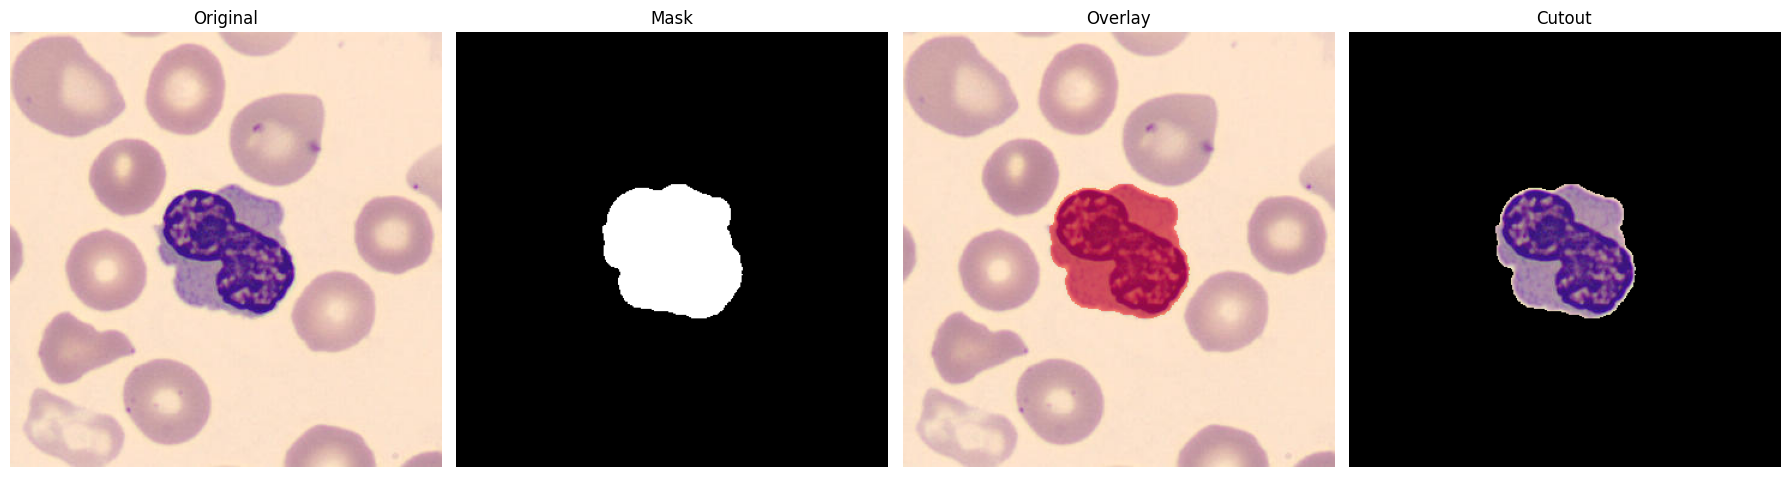

In [11]:
import matplotlib.pyplot as plt
from PIL import Image

# --- run segmentation ---
img_path = "/content/Wbc/original_images/original_images/erythroblast/ERB_112663.jpg"

mask01 = segment_wbc_image(
    img_path,
    ckpt_path="/content/segformer_wbc_best_lastlayer.pt",  # change if your ckpt is elsewhere
    backbone_id="nvidia/segformer-b3-finetuned-ade-512-512",
    threshold=0.5
)

mask_img, overlay, cutout = visualize_segmentation(img_path, mask01)

# --- visualize with matplotlib ---
fig, ax = plt.subplots(1, 4, figsize=(18, 5))

ax[0].imshow(Image.open(img_path).convert("RGB"))
ax[0].set_title("Original")
ax[0].axis("off")

ax[1].imshow(mask_img, cmap="gray")
ax[1].set_title("Mask")
ax[1].axis("off")

ax[2].imshow(overlay)
ax[2].set_title("Overlay")
ax[2].axis("off")

ax[3].imshow(cutout)
ax[3].set_title("Cutout")
ax[3].axis("off")

plt.tight_layout()
plt.show()


In [12]:
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms


class WBCSegmentationROIDataset(Dataset):
    """
    Returns:
      image      : Tensor [3,H,W]  (original image)
      roi        : Tensor [3,H,W]  (segmented cutout / ROI)
      label      : int             (class index)
    """

    def __init__(
        self,
        root_dir: str,
        ckpt_path: str,
        backbone_id: str = "nvidia/segformer-b3-finetuned-ade-512-512",
        threshold: float = 0.5,
        transform=None,
    ):
        """
        root_dir example:
        /content/Wbc/original_images/original_images
        """
        self.root_dir = root_dir
        self.ckpt_path = ckpt_path
        self.backbone_id = backbone_id
        self.threshold = threshold
        self.transform = transform

        # ---- discover classes from folder names ----
        self.classes = sorted(
            d for d in os.listdir(root_dir)
            if os.path.isdir(os.path.join(root_dir, d))
        )
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        # ---- collect image paths ----
        self.samples = []
        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            for fname in os.listdir(cls_dir):
                if fname.lower().endswith((".jpg", ".png", ".jpeg")):
                    self.samples.append(
                        (os.path.join(cls_dir, fname), self.class_to_idx[cls])
                    )

        if len(self.samples) == 0:
            raise RuntimeError("No images found in dataset.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        # ---- load image ----
        image = Image.open(img_path).convert("RGB")

        # ---- segmentation (model call) ----
        mask01 = segment_wbc_image(
            image=image,
            ckpt_path=self.ckpt_path,
            backbone_id=self.backbone_id,
            threshold=self.threshold,
        )

        # ---- ROI cutout (no model here) ----
        _, _, roi = visualize_segmentation(image, mask01)

        # ---- transforms ----
        if self.transform is not None:
            image = self.transform(image)
            roi = self.transform(roi)
        else:
            image = transforms.ToTensor()(image)
            roi = transforms.ToTensor()(roi)

        return image, roi, label


In [13]:
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = WBCSegmentationROIDataset(
    root_dir="/content/Wbc/original_images/original_images",
    ckpt_path="/content/segformer_wbc_best_lastlayer.pt",
    transform=transform,
)

loader = DataLoader(dataset, batch_size=8, shuffle=True)

# test one batch
images, rois, labels = next(iter(loader))
print(images.shape)   # [B,3,224,224]
print(rois.shape)     # [B,3,224,224]
print(labels.shape)   # [B]


torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8])


In [16]:
import random
import matplotlib.pyplot as plt

# ---- make sure dataset is already created ----
# dataset = WBCSegmentationROIDataset(...)

def visualize_random_samples(dataset, n=10):
    assert n <= len(dataset), "n larger than dataset size"

    indices = random.sample(range(len(dataset)), n)

    fig, axes = plt.subplots(n, 2, figsize=(8, 4 * n))

    for row, idx in enumerate(indices):
        image, roi, label = dataset[idx]

        # tensor -> numpy
        image_np = image.permute(1, 2, 0).numpy()
        roi_np = roi.permute(1, 2, 0).numpy()

        class_name = dataset.classes[label]

        axes[row, 0].imshow(image_np)
        axes[row, 0].set_title(f"{class_name}")
        axes[row, 0].axis("off")

        axes[row, 1].imshow(roi_np)
        axes[row, 1].set_title("ROI (Segmented Cutout)")
        axes[row, 1].axis("off")

    plt.tight_layout()
    plt.show()


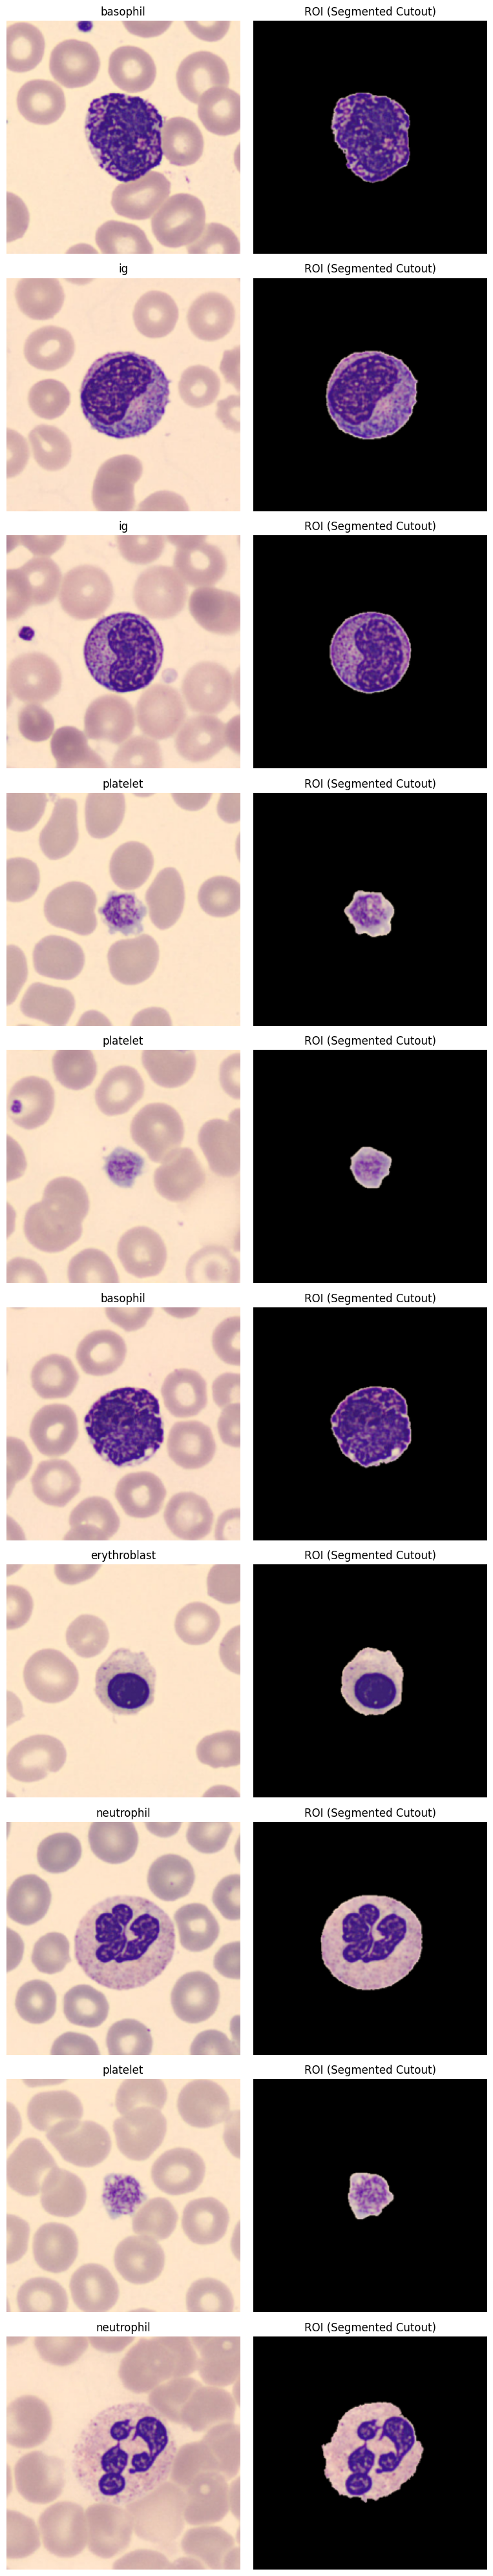

In [17]:
visualize_random_samples(dataset, n=10)


Classes: ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']
Split sizes: 936 312 312
Epoch 01/10 | train loss 1.9452 acc 0.2489 | val loss 1.7150 acc 0.3045
Epoch 02/10 | train loss 1.3038 acc 0.5182 | val loss 0.9400 acc 0.6282
Epoch 03/10 | train loss 0.8237 acc 0.7009 | val loss 0.6666 acc 0.7885
Epoch 04/10 | train loss 0.5775 acc 0.8034 | val loss 0.5409 acc 0.7724
Epoch 05/10 | train loss 0.4779 acc 0.8173 | val loss 0.4608 acc 0.8462
Epoch 06/10 | train loss 0.3088 acc 0.8932 | val loss 0.4438 acc 0.8301
Epoch 07/10 | train loss 0.2463 acc 0.9060 | val loss 0.4424 acc 0.8462
Epoch 08/10 | train loss 0.1896 acc 0.9359 | val loss 0.3508 acc 0.8686
Epoch 09/10 | train loss 0.1260 acc 0.9562 | val loss 0.3344 acc 0.8846
Epoch 10/10 | train loss 0.0980 acc 0.9744 | val loss 0.3133 acc 0.8942

✅ TEST | loss 0.1827 acc 0.9263


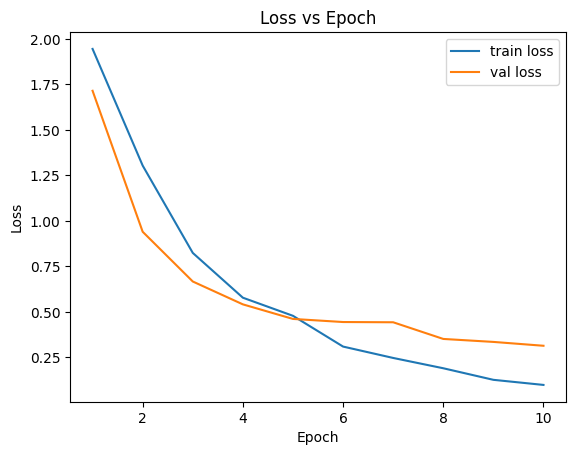

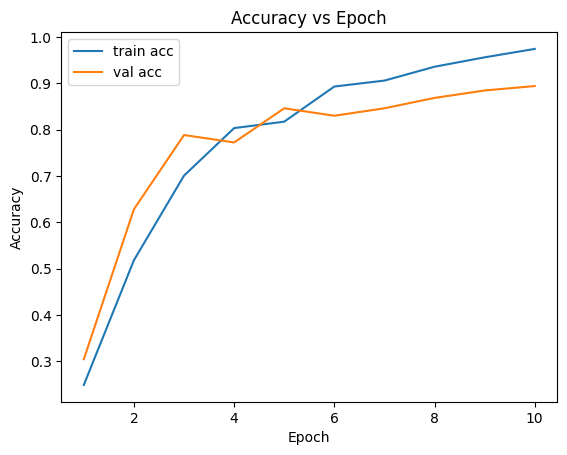

In [19]:
# =========================
# 0) Imports
# =========================
import os
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.models import vit_b_16, ViT_B_16_Weights
import matplotlib.pyplot as plt


# =========================
# 1) Reproducibility
# =========================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)


# =========================
# 2) Split helpers (60/20/20)
# =========================
def split_indices(n, train_ratio=0.6, val_ratio=0.2, seed=42):
    assert abs(train_ratio + val_ratio - 0.8) < 1e-9, "train+val must be 0.8 for 60/20/20"
    idx = list(range(n))
    rng = random.Random(seed)
    rng.shuffle(idx)

    n_train = int(round(n * train_ratio))
    n_val   = int(round(n * val_ratio))
    # ensure total sums to n
    n_train = min(n_train, n)
    n_val = min(n_val, n - n_train)
    n_test = n - n_train - n_val

    train_idx = idx[:n_train]
    val_idx   = idx[n_train:n_train + n_val]
    test_idx  = idx[n_train + n_val:]
    assert len(train_idx) + len(val_idx) + len(test_idx) == n
    return train_idx, val_idx, test_idx


# =========================
# 3) ROI-only wrapper dataset
# =========================
class ROIDatasetOnly(torch.utils.data.Dataset):
    def __init__(self, base_dataset):
        self.base = base_dataset
        self.classes = getattr(base_dataset, "classes", None)

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        _img, roi, label = self.base[idx]
        return roi, label


# =========================
# 4) Build dataset + dataloaders
# =========================

# ---- ViT preprocessing ----
weights = ViT_B_16_Weights.DEFAULT
# This gives a recommended normalization; we still set size explicitly.
vit_preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=weights.transforms().mean, std=weights.transforms().std),
])

# ---- Build your segmentation→ROI dataset ----
base_dataset = WBCSegmentationROIDataset(
    root_dir="/content/Wbc/original_images/original_images",
    ckpt_path="/content/segformer_wbc_best_lastlayer.pt",
    backbone_id="nvidia/segformer-b3-finetuned-ade-512-512",
    threshold=0.5,
    transform=vit_preprocess,
)

roi_dataset = ROIDatasetOnly(base_dataset)

train_idx, val_idx, test_idx = split_indices(len(roi_dataset), 0.6, 0.2, seed=42)

train_ds = Subset(roi_dataset, train_idx)
val_ds   = Subset(roi_dataset, val_idx)
test_ds  = Subset(roi_dataset, test_idx)

BATCH_SIZE = 32
NUM_WORKERS = 2  # set 0 if you get multiprocessing issues in Colab

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)


num_classes = len(base_dataset.classes)
print("Classes:", base_dataset.classes)
print("Split sizes:", len(train_ds), len(val_ds), len(test_ds))


# =========================
# 5) ViT model (pretrained) for classification
# =========================
device = "cuda" if torch.cuda.is_available() else "cpu"

model = vit_b_16(weights=weights)
# Replace classification head
in_features = model.heads.head.in_features
model.heads.head = nn.Linear(in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

# optional but useful
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)


# =========================
# 6) Train / Eval loops with metrics storage
# =========================
def accuracy_from_logits(logits, y):
    preds = torch.argmax(logits, dim=1)
    return (preds == y).float().mean().item()

def run_one_epoch(model, loader, train=True):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    total_correct = 0
    total = 0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        if train:
            optimizer.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(train):
            logits = model(x)
            loss = criterion(logits, y)

            if train:
                loss.backward()
                optimizer.step()

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_correct += (torch.argmax(logits, dim=1) == y).sum().item()
        total += bs

    avg_loss = total_loss / max(total, 1)
    avg_acc = total_correct / max(total, 1)
    return avg_loss, avg_acc


EPOCHS = 10
history = {
    "train_loss": [],
    "train_acc":  [],
    "val_loss":   [],
    "val_acc":    [],
}

best_val_acc = -1.0
best_state = None

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = run_one_epoch(model, train_loader, train=True)
    va_loss, va_acc = run_one_epoch(model, val_loader,   train=False)

    scheduler.step()

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(va_acc)

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
          f"val loss {va_loss:.4f} acc {va_acc:.4f}")

# Load best
if best_state is not None:
    model.load_state_dict(best_state)

# Test evaluation
test_loss, test_acc = run_one_epoch(model, test_loader, train=False)
print(f"\n✅ TEST | loss {test_loss:.4f} acc {test_acc:.4f}")


# =========================
# 7) Plot loss & accuracy
# =========================
epochs = np.arange(1, EPOCHS + 1)

plt.figure()
plt.plot(epochs, history["train_loss"], label="train loss")
plt.plot(epochs, history["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, history["train_acc"], label="train acc")
plt.plot(epochs, history["val_acc"], label="val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()
plt.show()


# =========================
# 8) (Optional) Save metrics + model
# =========================
# torch.save({"history": history, "test_loss": test_loss, "test_acc": test_acc}, "vit_roi_metrics.pt")
# torch.save(model.state_dict(), "vit_roi_best.pt")


✅ Inference done.
N test samples: 312
Num classes: 8
Classes: ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']

=== TEST METRICS ===
Accuracy:            0.9263  (95% Wilson CI: 0.8918 – 0.9504)
Balanced Accuracy:   0.9230  (bootstrap 95% CI: 0.8893 – 0.9511)
Macro Precision:     0.9236
Macro Recall:        0.9230
Macro F1:            0.9221  (bootstrap 95% CI: 0.8865 – 0.9490)
Weighted F1:         0.9275
Top-3 Acc:           1.0000
Top-5 Acc:           1.0000
Log Loss:            0.1827
Cohen’s Kappa:       0.9155
Matthews Corrcoef:   0.9159
ROC-AUC (OVR macro): 0.9953
Chance baseline p0=1/K=0.1250 | z=42.796 | approx p-value=0.000e+00

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

    basophil       0.93      0.95      0.94        41
  eosinophil       1.00      0.97      0.99        37
erythroblast       1.00      0.87      0.93        45
          ig       0.72      0.84      0.78        31
 

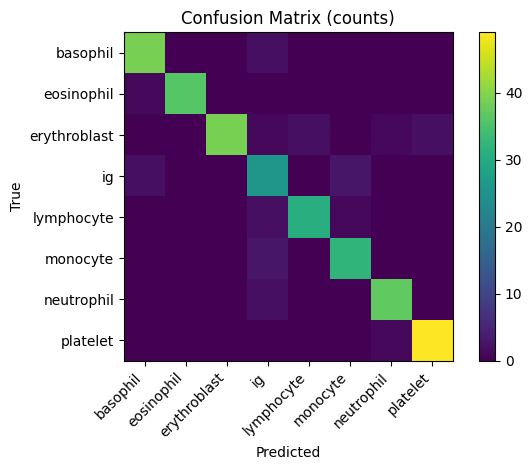

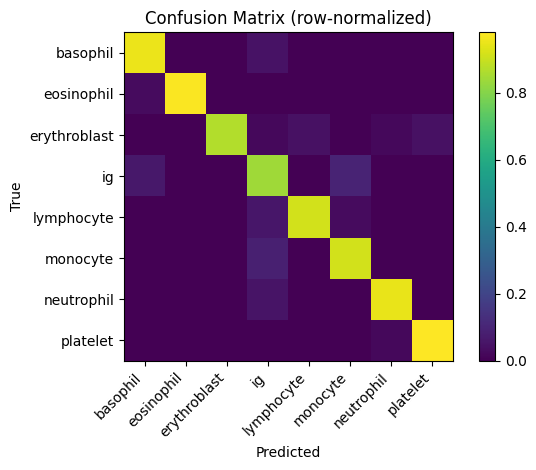

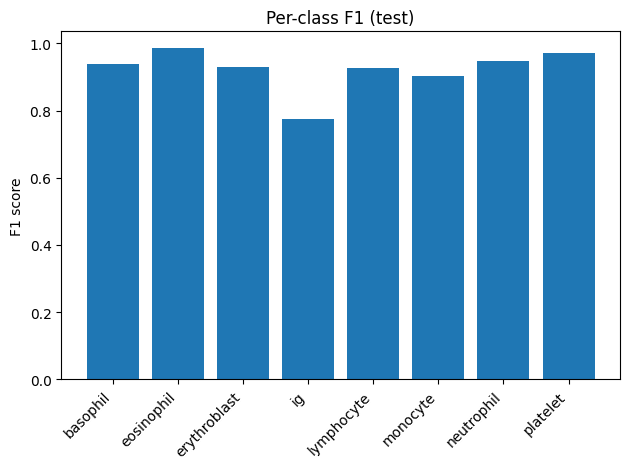

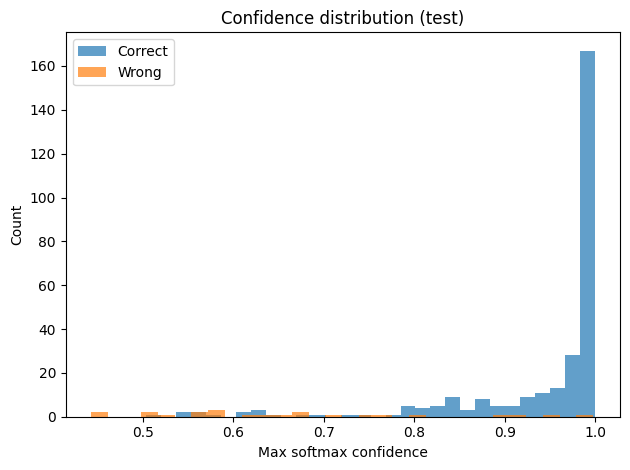

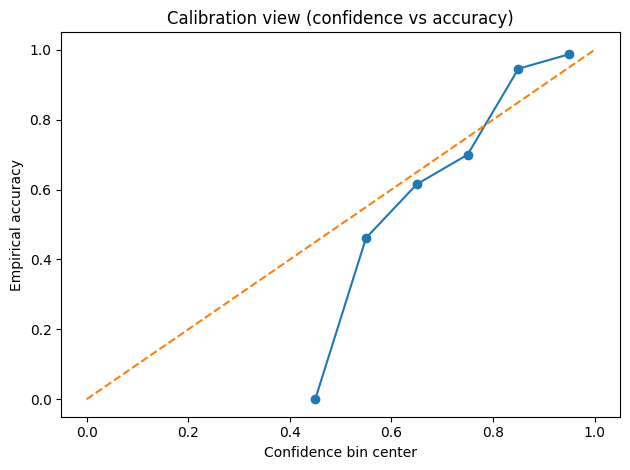


✅ Saved: test_inference_results.pt


In [20]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix, classification_report,
    roc_auc_score, log_loss,
    cohen_kappa_score, matthews_corrcoef,
    top_k_accuracy_score
)

# ----------------------------
# Helper: Wilson CI for accuracy
# ----------------------------
def wilson_ci(k, n, z=1.96):
    if n == 0:
        return (np.nan, np.nan)
    p = k / n
    denom = 1 + z**2 / n
    center = (p + z**2/(2*n)) / denom
    half = (z * np.sqrt((p*(1-p)/n) + (z**2/(4*n**2)))) / denom
    return center - half, center + half

# ----------------------------
# Helper: Bootstrap CI for any metric
# ----------------------------
def bootstrap_ci(y_true, y_pred, metric_fn, B=1000, seed=42):
    rng = np.random.default_rng(seed)
    n = len(y_true)
    stats = []
    idx = np.arange(n)
    for _ in range(B):
        samp = rng.choice(idx, size=n, replace=True)
        stats.append(metric_fn(y_true[samp], y_pred[samp]))
    stats = np.asarray(stats)
    return np.percentile(stats, 2.5), np.percentile(stats, 97.5)

# ----------------------------
# Inference on test set
# ----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model.eval()

all_y = []
all_pred = []
all_prob = []
all_conf = []  # max softmax confidence

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        logits = model(x)
        probs = F.softmax(logits, dim=1)

        pred = torch.argmax(probs, dim=1)
        conf = torch.max(probs, dim=1).values

        all_y.append(y.cpu().numpy())
        all_pred.append(pred.cpu().numpy())
        all_prob.append(probs.cpu().numpy())
        all_conf.append(conf.cpu().numpy())

y_true = np.concatenate(all_y)
y_pred = np.concatenate(all_pred)
y_prob = np.concatenate(all_prob)
conf   = np.concatenate(all_conf)

num_classes = y_prob.shape[1]

# class names (prefer your dataset)
try:
    class_names = base_dataset.classes
except NameError:
    class_names = [f"class_{i}" for i in range(num_classes)]

print("✅ Inference done.")
print("N test samples:", len(y_true))
print("Num classes:", num_classes)
print("Classes:", class_names)

# ----------------------------
# Core metrics
# ----------------------------
acc = accuracy_score(y_true, y_pred)
bal_acc = balanced_accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)

prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true, y_pred, average="macro", zero_division=0
)
prec_weight, rec_weight, f1_weight, _ = precision_recall_fscore_support(
    y_true, y_pred, average="weighted", zero_division=0
)

# top-k
top3 = top_k_accuracy_score(y_true, y_prob, k=min(3, num_classes), labels=list(range(num_classes)))
top5 = top_k_accuracy_score(y_true, y_prob, k=min(5, num_classes), labels=list(range(num_classes)))

# log loss (cross-entropy on probs)
ll = log_loss(y_true, y_prob, labels=list(range(num_classes)))

# AUC (one-vs-rest) if possible
auc_ovr = None
try:
    # need one-hot y
    y_onehot = np.eye(num_classes)[y_true]
    auc_ovr = roc_auc_score(y_onehot, y_prob, average="macro", multi_class="ovr")
except Exception as e:
    auc_ovr = None

# Accuracy CI (Wilson)
k_correct = int((y_true == y_pred).sum())
acc_ci = wilson_ci(k_correct, len(y_true))

# Bootstrap CI for macro-F1 and balanced accuracy
f1_ci = bootstrap_ci(y_true, y_pred, lambda a,b: precision_recall_fscore_support(a,b,average="macro",zero_division=0)[2])
bal_ci = bootstrap_ci(y_true, y_pred, lambda a,b: balanced_accuracy_score(a,b))

# Binomial test vs chance baseline (approx): compare accuracy vs 1/num_classes
# We'll compute z-test style p-value (works fine for quick stats).
p0 = 1.0 / num_classes
n = len(y_true)
phat = acc
# normal approximation to binomial
se = np.sqrt(p0*(1-p0)/n)
z = (phat - p0) / (se + 1e-12)
# two-sided p-value
from math import erf, sqrt
p_value = 2 * (1 - 0.5*(1 + erf(abs(z)/sqrt(2))))

print("\n=== TEST METRICS ===")
print(f"Accuracy:            {acc:.4f}  (95% Wilson CI: {acc_ci[0]:.4f} – {acc_ci[1]:.4f})")
print(f"Balanced Accuracy:   {bal_acc:.4f}  (bootstrap 95% CI: {bal_ci[0]:.4f} – {bal_ci[1]:.4f})")
print(f"Macro Precision:     {prec_macro:.4f}")
print(f"Macro Recall:        {rec_macro:.4f}")
print(f"Macro F1:            {f1_macro:.4f}  (bootstrap 95% CI: {f1_ci[0]:.4f} – {f1_ci[1]:.4f})")
print(f"Weighted F1:         {f1_weight:.4f}")
print(f"Top-3 Acc:           {top3:.4f}")
print(f"Top-5 Acc:           {top5:.4f}")
print(f"Log Loss:            {ll:.4f}")
print(f"Cohen’s Kappa:       {kappa:.4f}")
print(f"Matthews Corrcoef:   {mcc:.4f}")
print(f"ROC-AUC (OVR macro): {auc_ovr:.4f}" if auc_ovr is not None else "ROC-AUC (OVR macro): n/a")
print(f"Chance baseline p0=1/K={p0:.4f} | z={z:.3f} | approx p-value={p_value:.3e}")

print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

# ----------------------------
# Per-class stats table arrays
# ----------------------------
prec_c, rec_c, f1_c, sup_c = precision_recall_fscore_support(y_true, y_pred, average=None, zero_division=0)

print("\n=== PER-CLASS SUMMARY ===")
for i, name in enumerate(class_names):
    print(f"{name:12s} | support={sup_c[i]:4d} | P={prec_c[i]:.3f} R={rec_c[i]:.3f} F1={f1_c[i]:.3f}")

# ----------------------------
# Confusion matrix
# ----------------------------
cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))

plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (counts)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(np.arange(num_classes), class_names, rotation=45, ha="right")
plt.yticks(np.arange(num_classes), class_names)
plt.colorbar()
plt.tight_layout()
plt.show()

# normalized confusion matrix (row-normalized)
cm_norm = cm / (cm.sum(axis=1, keepdims=True) + 1e-12)

plt.figure()
plt.imshow(cm_norm, interpolation="nearest")
plt.title("Confusion Matrix (row-normalized)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(np.arange(num_classes), class_names, rotation=45, ha="right")
plt.yticks(np.arange(num_classes), class_names)
plt.colorbar()
plt.tight_layout()
plt.show()

# ----------------------------
# Per-class F1 bar plot
# ----------------------------
plt.figure()
plt.bar(np.arange(num_classes), f1_c)
plt.xticks(np.arange(num_classes), class_names, rotation=45, ha="right")
plt.ylabel("F1 score")
plt.title("Per-class F1 (test)")
plt.tight_layout()
plt.show()

# ----------------------------
# Confidence analysis (correct vs wrong)
# ----------------------------
correct = (y_true == y_pred)
plt.figure()
plt.hist(conf[correct], bins=30, alpha=0.7, label="Correct")
plt.hist(conf[~correct], bins=30, alpha=0.7, label="Wrong")
plt.xlabel("Max softmax confidence")
plt.ylabel("Count")
plt.title("Confidence distribution (test)")
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------
# Simple calibration view: bin confidence -> empirical accuracy
# ----------------------------
bins = np.linspace(0, 1, 11)
bin_ids = np.digitize(conf, bins) - 1
bin_acc = []
bin_centers = []
for b in range(len(bins) - 1):
    m = (bin_ids == b)
    if m.sum() == 0:
        continue
    bin_acc.append(correct[m].mean())
    bin_centers.append((bins[b] + bins[b+1]) / 2)

plt.figure()
plt.plot(bin_centers, bin_acc, marker="o")
plt.plot([0,1],[0,1], linestyle="--")  # perfect calibration line
plt.xlabel("Confidence bin center")
plt.ylabel("Empirical accuracy")
plt.title("Calibration view (confidence vs accuracy)")
plt.tight_layout()
plt.show()

# ----------------------------
# Save everything
# ----------------------------
results = {
    "acc": acc,
    "acc_ci_wilson": acc_ci,
    "balanced_acc": bal_acc,
    "balanced_acc_ci_bootstrap": bal_ci,
    "macro_f1": f1_macro,
    "macro_f1_ci_bootstrap": f1_ci,
    "weighted_f1": f1_weight,
    "macro_precision": prec_macro,
    "macro_recall": rec_macro,
    "kappa": kappa,
    "mcc": mcc,
    "top3": top3,
    "top5": top5,
    "log_loss": ll,
    "auc_ovr_macro": auc_ovr,
    "chance_p_value_approx": p_value,
    "per_class": {
        "precision": prec_c,
        "recall": rec_c,
        "f1": f1_c,
        "support": sup_c,
        "names": class_names
    },
    "confusion_matrix": cm,
    "confusion_matrix_norm": cm_norm,
}

torch.save(results, "test_inference_results.pt")
print("\n✅ Saved: test_inference_results.pt")


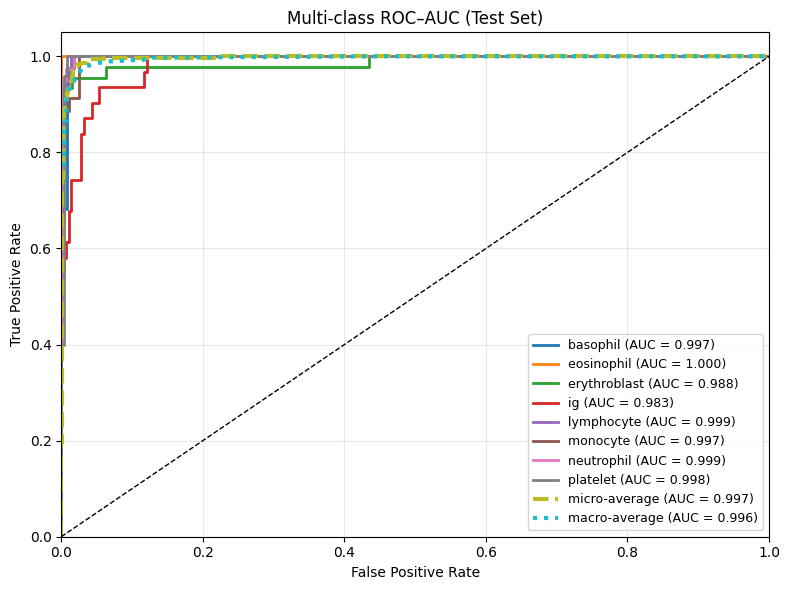

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# --------------------------------
# Binarize labels (one-vs-rest)
# --------------------------------
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))

# --------------------------------
# Compute ROC curves + AUC
# --------------------------------
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# -------- micro-average --------
fpr["micro"], tpr["micro"], _ = roc_curve(
    y_true_bin.ravel(), y_prob.ravel()
)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# -------- macro-average --------
# Aggregate all FPRs
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Interpolate TPRs
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# --------------------------------
# Plot
# --------------------------------
plt.figure(figsize=(8, 6))

# Per-class ROC
for i, name in enumerate(class_names):
    plt.plot(
        fpr[i], tpr[i],
        lw=2,
        label=f"{name} (AUC = {roc_auc[i]:.3f})"
    )

# Micro & Macro
plt.plot(
    fpr["micro"], tpr["micro"],
    linestyle="--", linewidth=3,
    label=f"micro-average (AUC = {roc_auc['micro']:.3f})"
)

plt.plot(
    fpr["macro"], tpr["macro"],
    linestyle=":", linewidth=3,
    label=f"macro-average (AUC = {roc_auc['macro']:.3f})"
)

# Chance line
plt.plot([0, 1], [0, 1], "k--", lw=1)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC–AUC (Test Set)")
plt.legend(loc="lower right", fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


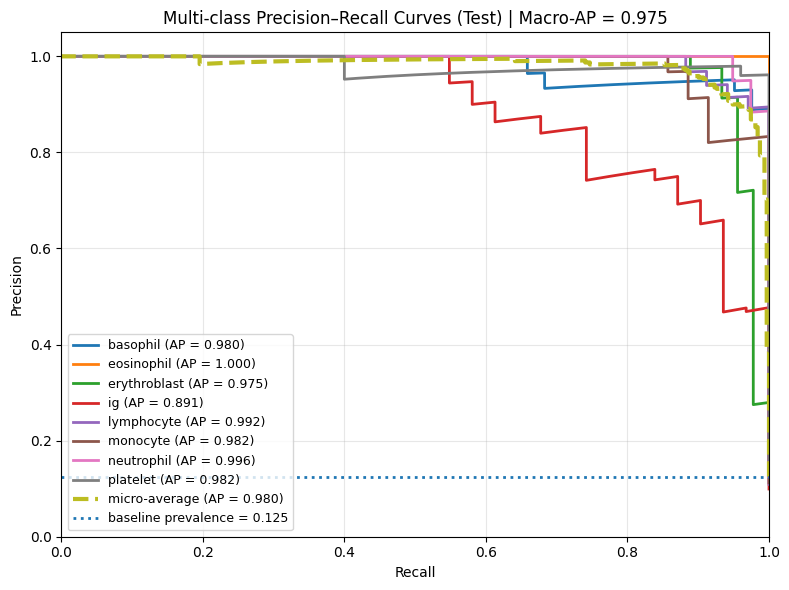

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Assumes you already have:
# y_true: (N,) int labels
# y_prob: (N,C) probabilities
# class_names: list of length C
# num_classes: C

# ----------------------------
# Binarize labels (one-vs-rest)
# ----------------------------
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))

# ----------------------------
# Compute PR + AP per class
# ----------------------------
prec = {}
rec = {}
ap = {}

for i in range(num_classes):
    prec[i], rec[i], _ = precision_recall_curve(y_true_bin[:, i], y_prob[:, i])
    ap[i] = average_precision_score(y_true_bin[:, i], y_prob[:, i])

# Micro-average PR (global)
prec["micro"], rec["micro"], _ = precision_recall_curve(y_true_bin.ravel(), y_prob.ravel())
ap["micro"] = average_precision_score(y_true_bin, y_prob, average="micro")

# Macro-average AP (mean of per-class APs)
ap["macro"] = float(np.mean([ap[i] for i in range(num_classes)]))

# ----------------------------
# Plot Precision–Recall curves
# ----------------------------
plt.figure(figsize=(8, 6))

# Per-class curves
for i, name in enumerate(class_names):
    plt.plot(
        rec[i], prec[i],
        lw=2,
        label=f"{name} (AP = {ap[i]:.3f})"
    )

# Micro-average curve
plt.plot(
    rec["micro"], prec["micro"],
    linestyle="--", linewidth=3,
    label=f"micro-average (AP = {ap['micro']:.3f})"
)

# Baseline (prevalence) lines per-class can clutter; show a single overall prevalence baseline
overall_prevalence = y_true_bin.mean()
plt.hlines(
    overall_prevalence, 0, 1,
    linestyles=":", linewidth=2,
    label=f"baseline prevalence = {overall_prevalence:.3f}"
)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Multi-class Precision–Recall Curves (Test) | Macro-AP = {ap['macro']:.3f}")
plt.legend(loc="lower left", fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


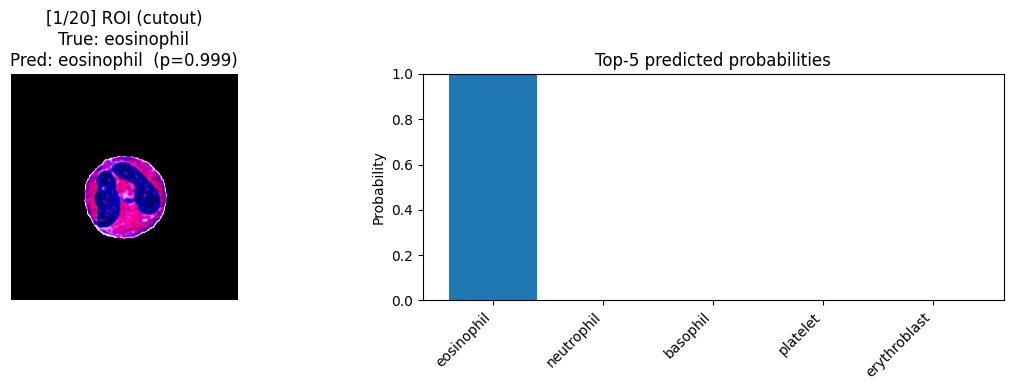

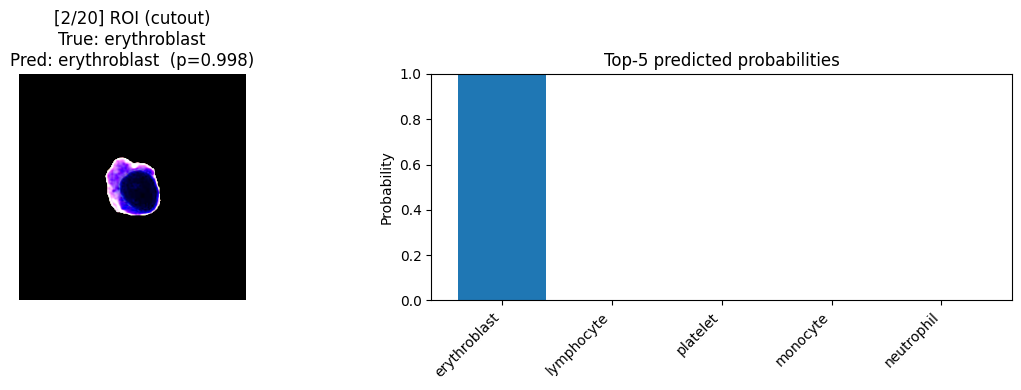

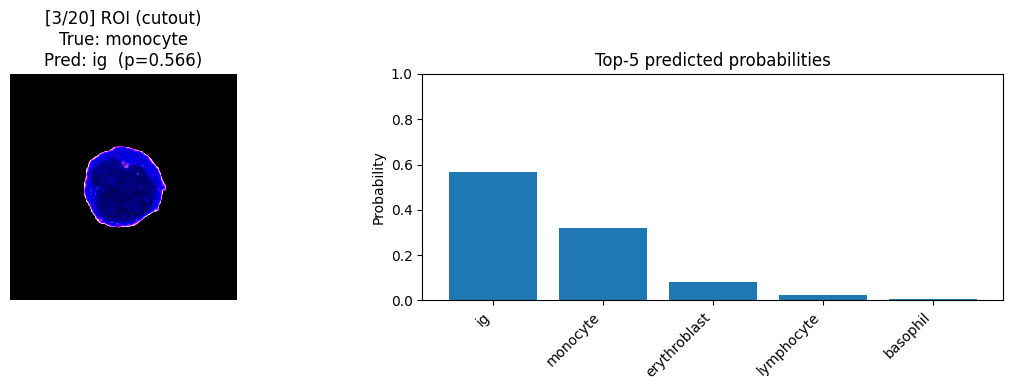

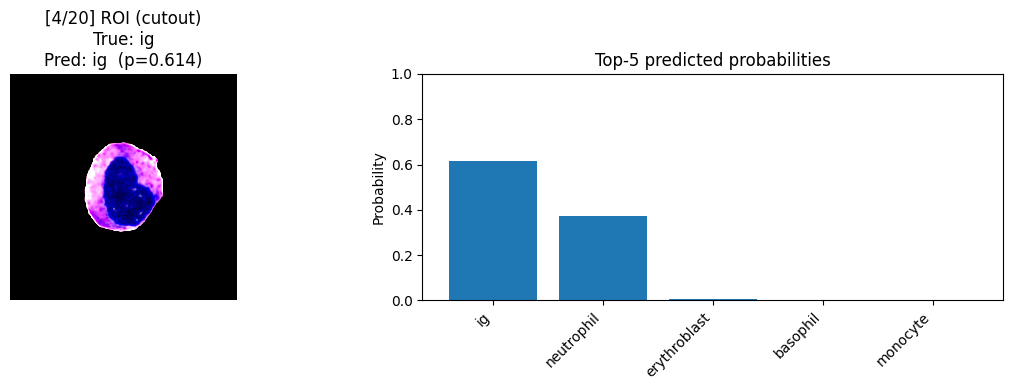

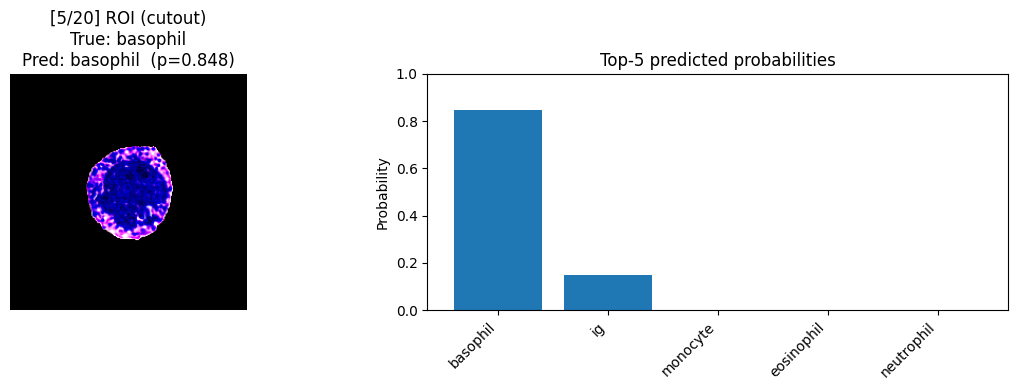

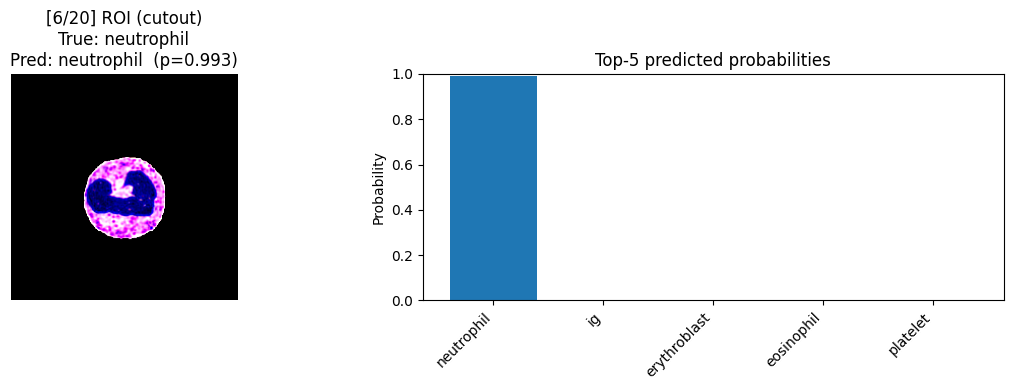

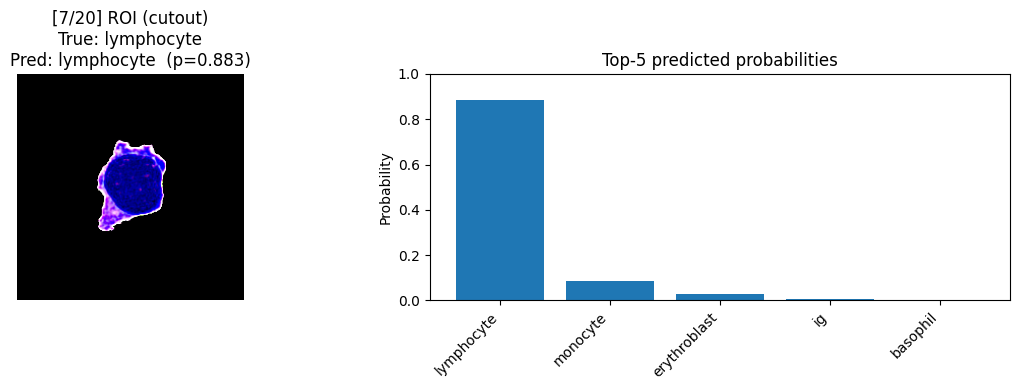

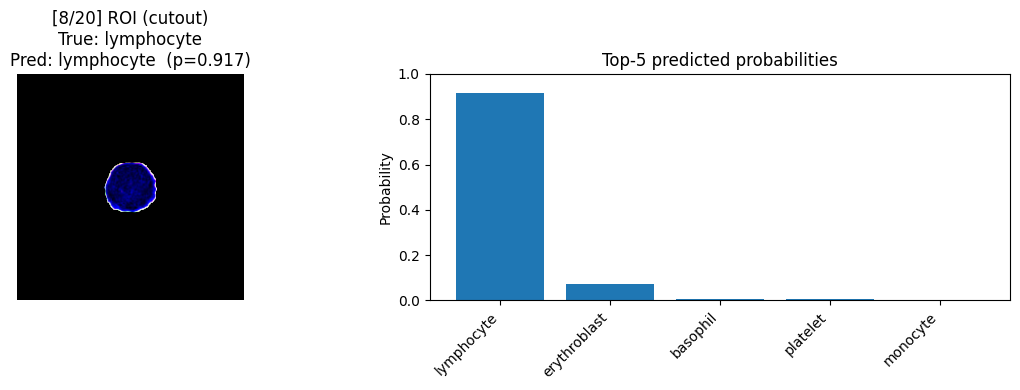

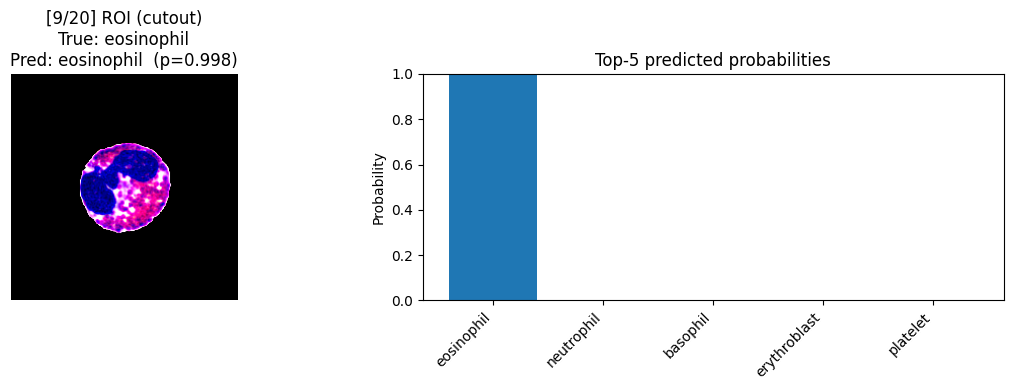

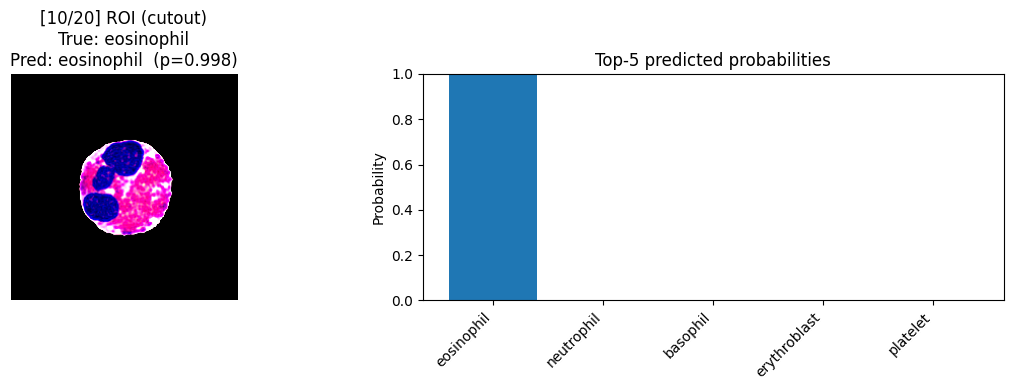

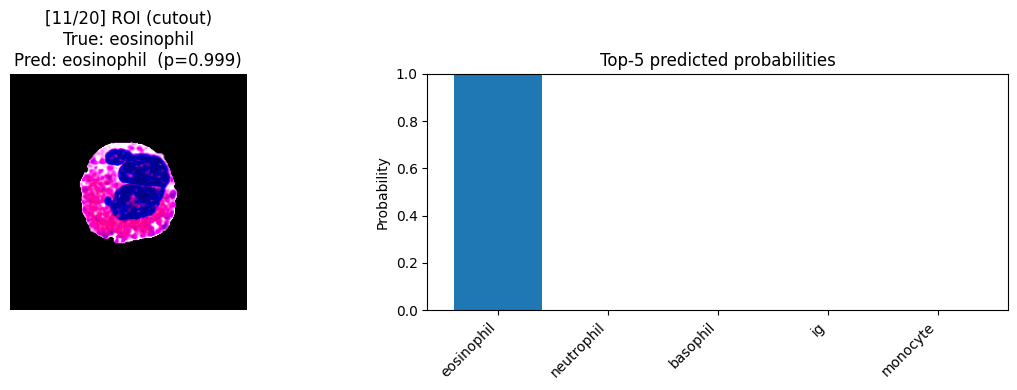

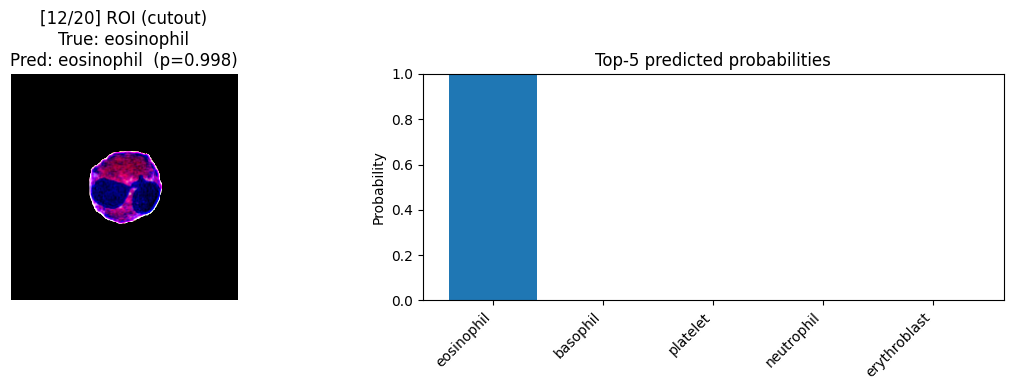

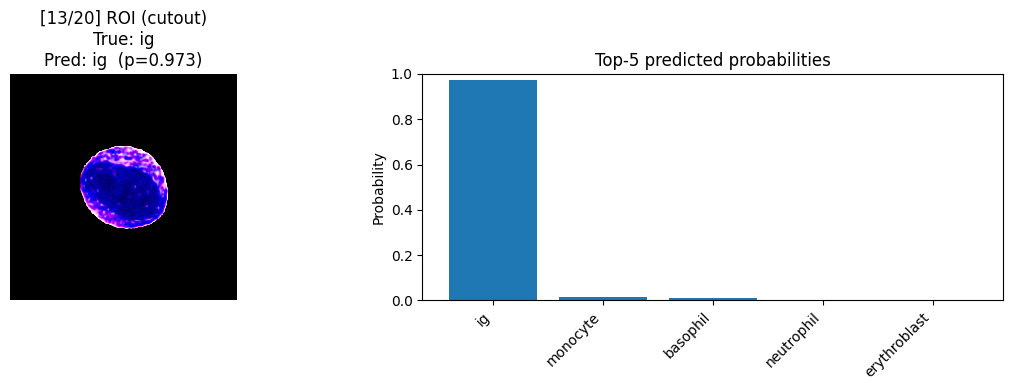

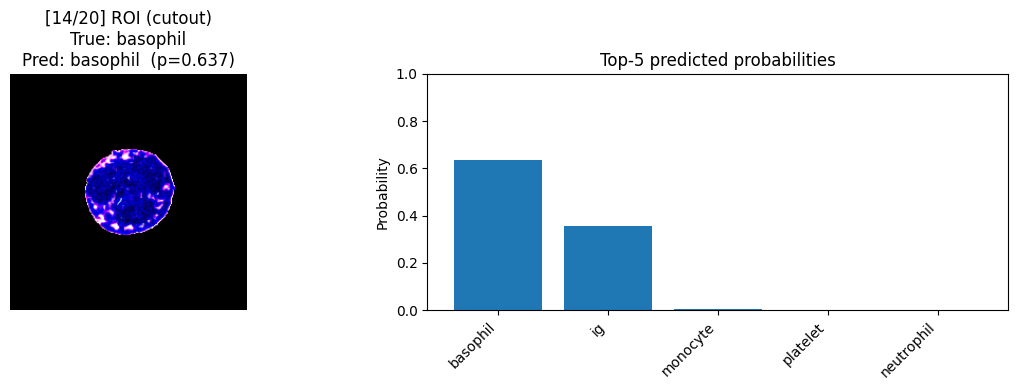

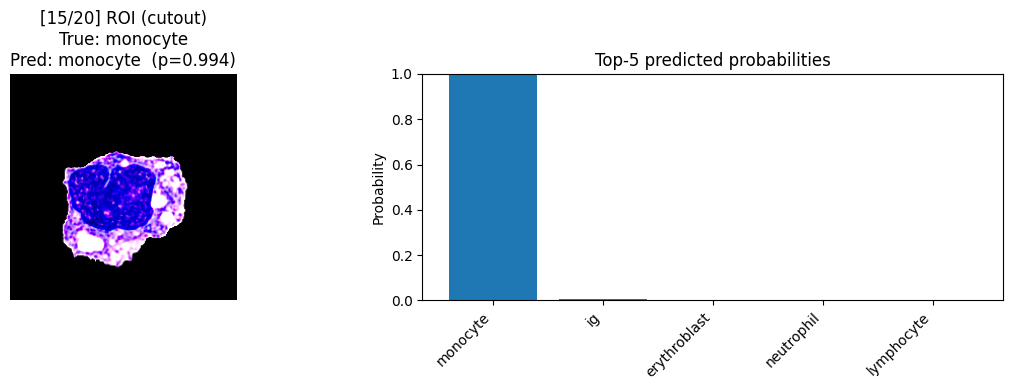

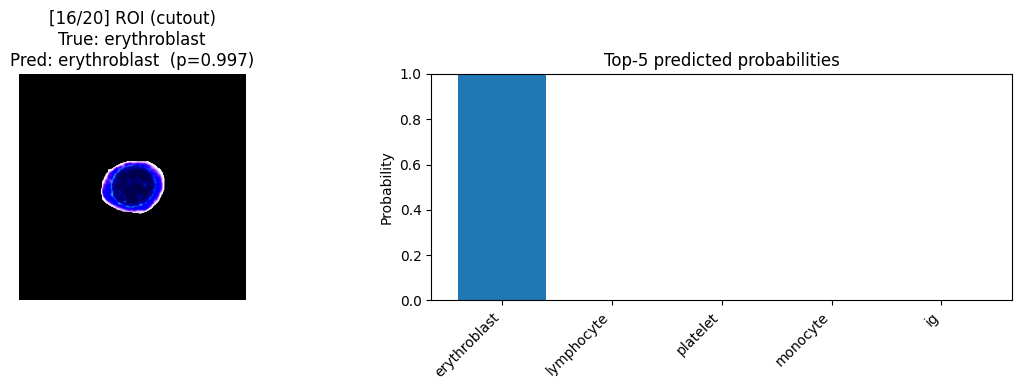

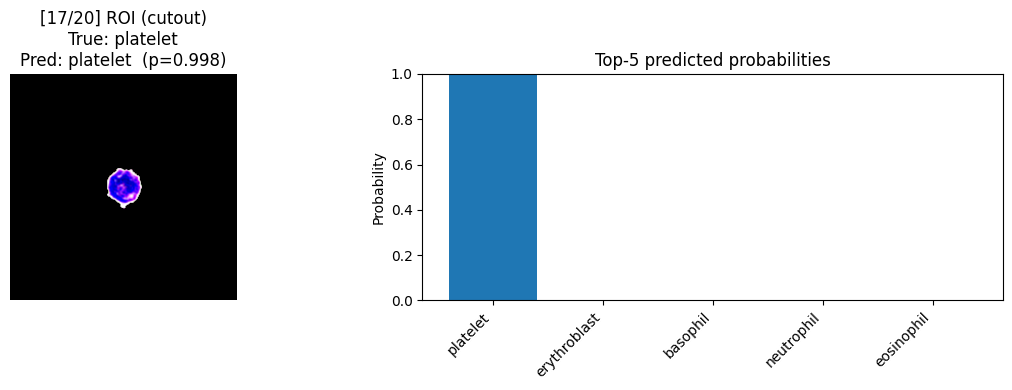

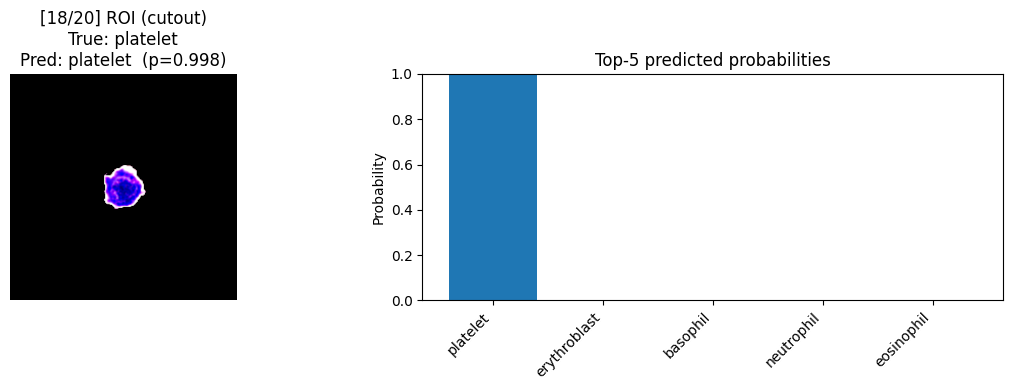

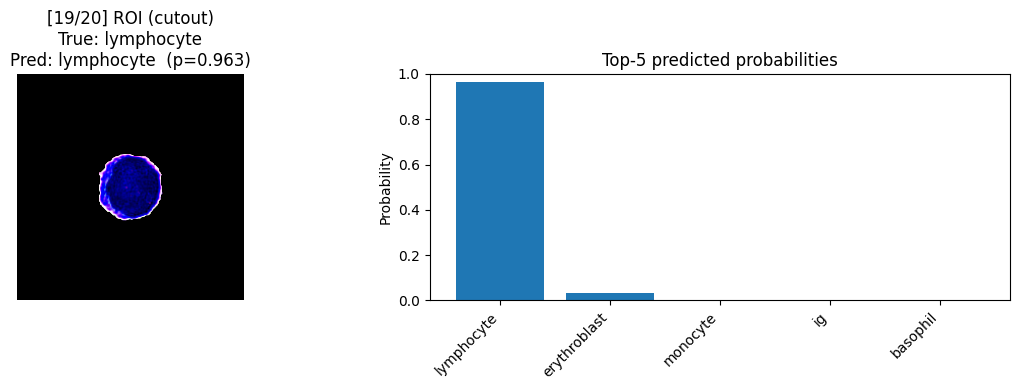

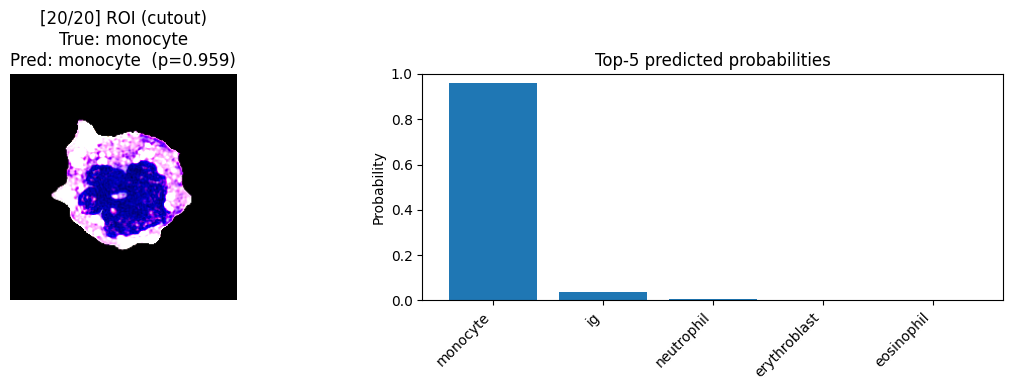

In [23]:
import random
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ---- assumes you already have these ----
# model, test_ds (Subset), base_dataset.classes (or class_names)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.eval()

try:
    class_names = base_dataset.classes
except NameError:
    # fallback if you stored it elsewhere
    class_names = [f"class_{i}" for i in range(model.heads.head.out_features)]

def tensor_to_img01(x):
    """
    Convert normalized tensor [3,H,W] -> displayable float image [H,W,3] in [0,1].
    This is for visualization only (we do NOT un-normalize perfectly; we just clamp).
    """
    x = x.detach().cpu()
    x = x.permute(1, 2, 0).numpy()
    x = np.clip(x, 0, 1)
    return x

@torch.no_grad()
def infer_one(x_tensor):
    x = x_tensor.unsqueeze(0).to(device)
    logits = model(x)
    probs = F.softmax(logits, dim=1)[0].detach().cpu().numpy()
    pred = int(np.argmax(probs))
    conf = float(probs[pred])
    return pred, conf, probs

# -------- pick 20 random indices from test subset --------
N = 20
N = min(N, len(test_ds))
indices = random.sample(range(len(test_ds)), N)

for i, idx in enumerate(indices, start=1):
    roi, y = test_ds[idx]  # roi: [3,H,W], y: int
    pred, conf, probs = infer_one(roi)

    true_name = class_names[int(y)]
    pred_name = class_names[pred]

    # top-k
    k = min(5, len(class_names))
    topk_idx = np.argsort(probs)[::-1][:k]
    topk_probs = probs[topk_idx]
    topk_names = [class_names[j] for j in topk_idx]

    # visualization layout: ROI + bar chart
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    ax[0].imshow(tensor_to_img01(roi))
    ax[0].set_title(
        f"[{i}/{N}] ROI (cutout)\n"
        f"True: {true_name}\n"
        f"Pred: {pred_name}  (p={conf:.3f})"
    )
    ax[0].axis("off")

    ax[1].bar(range(k), topk_probs)
    ax[1].set_xticks(range(k))
    ax[1].set_xticklabels(topk_names, rotation=45, ha="right")
    ax[1].set_ylim(0, 1.0)
    ax[1].set_ylabel("Probability")
    ax[1].set_title("Top-5 predicted probabilities")

    plt.tight_layout()
    plt.show()


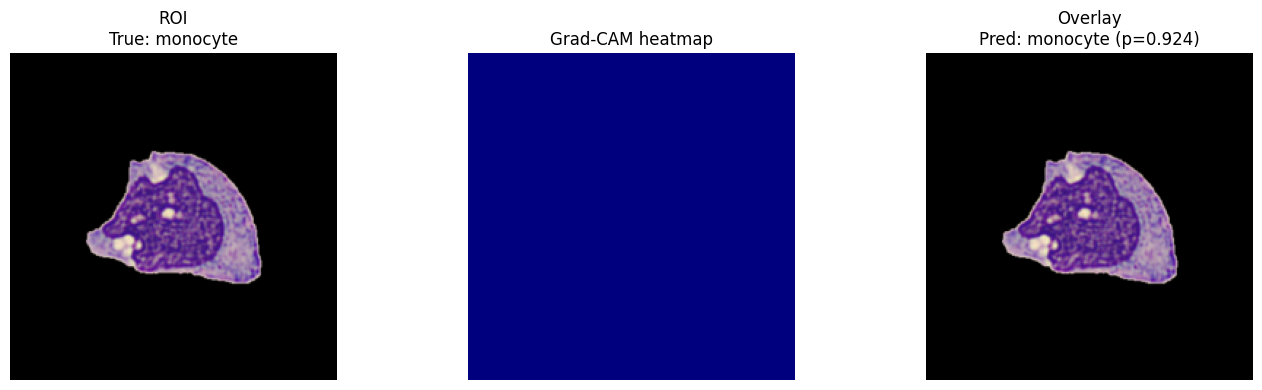

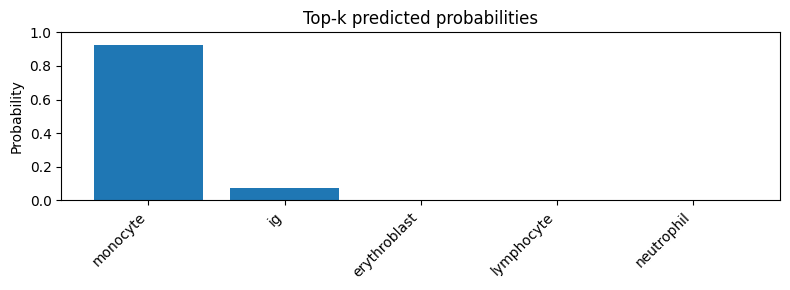

In [30]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.models import ViT_B_16_Weights

# ---------- nice visualization ----------
def unnormalize_vit(x: torch.Tensor, weights=ViT_B_16_Weights.DEFAULT):
    mean = torch.tensor(weights.transforms().mean, device=x.device).view(3,1,1)
    std  = torch.tensor(weights.transforms().std,  device=x.device).view(3,1,1)
    y = (x * std + mean).clamp(0, 1)
    return y.permute(1,2,0).detach().cpu().numpy()

def overlay_heatmap(img01: np.ndarray, heat01: np.ndarray, alpha=0.55):
    heat = heat01[..., None]
    red = np.zeros_like(img01); red[..., 0] = 1.0
    out = img01 * (1 - alpha * heat) + red * (alpha * heat)
    return np.clip(out, 0, 1)

# ---------- robust ViT Grad-CAM ----------
class ViTGradCAM_Robust:
    """
    Robust "Grad-CAM" for torchvision ViT:
    hooks encoder layernorm output tokens (CLS + patches).
    CAM = sum_c |grad * act| over channels, per patch.
    """
    def __init__(self, vit_model):
        self.model = vit_model
        self.tokens = None
        self.grads = None
        self.handles = []

        # best hook point: encoder final layernorm
        ln = self.model.encoder.ln

        def fwd_hook(module, inp, out):
            # out: (B, T, D)
            self.tokens = out
            self.tokens.retain_grad()

        def bwd_hook(module, grad_in, grad_out):
            self.grads = grad_out[0]  # (B, T, D)

        self.handles.append(ln.register_forward_hook(fwd_hook))
        self.handles.append(ln.register_full_backward_hook(bwd_hook))

    def remove(self):
        for h in self.handles:
            h.remove()
        self.handles = []

    def _grid(self, H, W):
        patch = self.model.conv_proj.kernel_size[0]  # vit_b_16 -> 16
        return H // patch, W // patch

    def __call__(self, x, target_class=None):
        """
        x: [1,3,H,W] normalized tensor
        returns: heat[H,W], pred_class, pred_prob, probs[C]
        """
        self.model.zero_grad(set_to_none=True)

        logits = self.model(x)                 # [1,C]
        probs = F.softmax(logits, dim=1)[0]    # [C]
        pred_class = int(probs.argmax().item())
        pred_prob = float(probs[pred_class].item())

        if target_class is None:
            target_class = pred_class

        score = logits[0, target_class]
        score.backward()

        # tokens/grads at encoder.ln output
        tokens = self.tokens[0]  # [T,D]
        grads  = self.grads[0]   # [T,D]

        # drop CLS token
        act = tokens[1:, :]      # [N,D]
        grad = grads[1:, :]      # [N,D]

        # robust CAM: |grad * act| summed over channels -> [N]
        cam = torch.abs(grad * act).sum(dim=1)

        # normalize safely
        cam = cam - cam.min()
        denom = cam.max() + 1e-8
        cam = cam / denom

        _, _, H, W = x.shape
        gh, gw = self._grid(H, W)
        cam_grid = cam.reshape(gh, gw)[None, None, ...]  # [1,1,gh,gw]

        cam_up = F.interpolate(cam_grid, size=(H, W), mode="bilinear", align_corners=False)[0,0]
        heat = cam_up.clamp(0, 1).detach().cpu().numpy()

        return heat, pred_class, pred_prob, probs.detach().cpu().numpy()

# =========================
# Example on ONE test sample
# =========================
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device).eval()

# class names
try:
    class_names = base_dataset.classes
except NameError:
    class_names = [f"class_{i}" for i in range(model.heads.head.out_features)]

cam_engine = ViTGradCAM_Robust(model)

idx = 0  # change
roi, y_true = test_ds[idx]
x = roi.unsqueeze(0).to(device)

heat, pred, pred_p, probs = cam_engine(x)

img01 = unnormalize_vit(roi.to(device))
overlay = overlay_heatmap(img01, heat, alpha=0.55)

true_name = class_names[int(y_true)]
pred_name = class_names[int(pred)]

topk = min(5, len(class_names))
top_idx = np.argsort(probs)[::-1][:topk]
top_probs = probs[top_idx]
top_names = [class_names[i] for i in top_idx]

plt.figure(figsize=(14,4))
plt.subplot(1,3,1); plt.imshow(img01); plt.title(f"ROI\nTrue: {true_name}"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(heat, cmap="jet"); plt.title("Grad-CAM heatmap"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(overlay); plt.title(f"Overlay\nPred: {pred_name} (p={pred_p:.3f})"); plt.axis("off")
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,3))
plt.bar(range(topk), top_probs)
plt.xticks(range(topk), top_names, rotation=45, ha="right")
plt.ylim(0,1)
plt.ylabel("Probability")
plt.title("Top-k predicted probabilities")
plt.tight_layout(); plt.show()

cam_engine.remove()


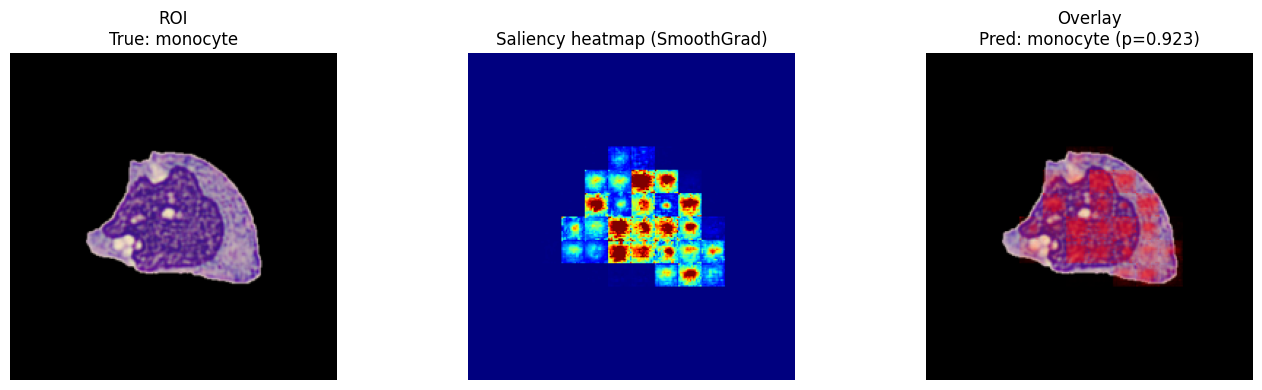

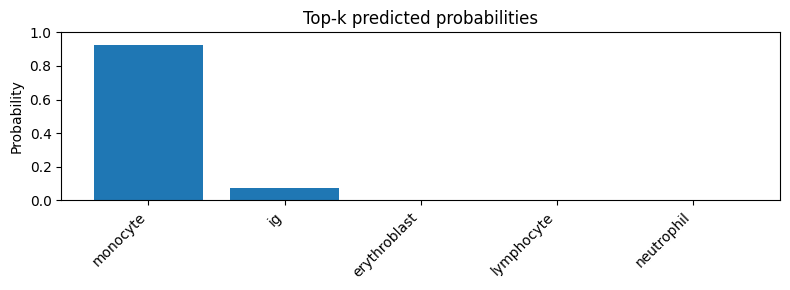

In [31]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.models import ViT_B_16_Weights

# -------------------------
# Helpers
# -------------------------
def unnormalize_vit(x: torch.Tensor, weights=ViT_B_16_Weights.DEFAULT):
    mean = torch.tensor(weights.transforms().mean, device=x.device).view(3,1,1)
    std  = torch.tensor(weights.transforms().std,  device=x.device).view(3,1,1)
    y = (x * std + mean).clamp(0, 1)
    return y.permute(1,2,0).detach().cpu().numpy()

def overlay_heatmap(img01: np.ndarray, heat01: np.ndarray, alpha=0.55):
    heat = heat01[..., None]
    red = np.zeros_like(img01); red[..., 0] = 1.0
    out = img01 * (1 - alpha * heat) + red * (alpha * heat)
    return np.clip(out, 0, 1)

def normalize_heatmap(h):
    # robust normalization: avoids "blank" from tiny ranges
    h = np.nan_to_num(h, nan=0.0, posinf=0.0, neginf=0.0)
    lo = np.percentile(h, 5)
    hi = np.percentile(h, 99)
    h = (h - lo) / (hi - lo + 1e-8)
    return np.clip(h, 0, 1)

# -------------------------
# Saliency (Input-Gradient)
# -------------------------
def saliency_map(model, x, target_class=None):
    """
    x: [1,3,H,W] tensor (normalized), requires_grad will be enabled inside
    returns: heat [H,W] in [0,1], pred_class, pred_prob, probs [C]
    """
    model.eval()
    x = x.clone().detach().requires_grad_(True)

    logits = model(x)                  # [1,C]
    probs = F.softmax(logits, dim=1)[0]
    pred = int(torch.argmax(probs).item())
    pred_p = float(probs[pred].item())

    if target_class is None:
        target_class = pred

    score = logits[0, target_class]
    model.zero_grad(set_to_none=True)
    if x.grad is not None:
        x.grad.zero_()
    score.backward()

    grad = x.grad.detach()[0]          # [3,H,W]
    heat = grad.abs().mean(dim=0).cpu().numpy()  # [H,W]

    heat = normalize_heatmap(heat)
    return heat, pred, pred_p, probs.detach().cpu().numpy()

# -------------------------
# SmoothGrad (more stable)
# -------------------------
def smoothgrad_saliency(model, x, target_class=None, n_samples=20, noise_std=0.10):
    """
    Averages saliency over noisy inputs for smoother maps.
    noise_std is relative to tensor scale (normalized space).
    """
    model.eval()
    x0 = x.clone().detach()

    heats = []
    pred = None
    pred_p = None
    probs0 = None

    for i in range(n_samples):
        noise = torch.randn_like(x0) * noise_std
        heat, pred_i, pred_p_i, probs_i = saliency_map(model, x0 + noise, target_class=target_class)
        heats.append(heat)
        if pred is None:
            pred, pred_p, probs0 = pred_i, pred_p_i, probs_i

    heat = np.mean(np.stack(heats, axis=0), axis=0)
    heat = normalize_heatmap(heat)
    return heat, pred, pred_p, probs0

# =========================
# RUN ON ONE TEST SAMPLE
# =========================
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device).eval()

try:
    class_names = base_dataset.classes
except NameError:
    class_names = [f"class_{i}" for i in range(model.heads.head.out_features)]

idx = 0  # change this
roi, y_true = test_ds[idx]
x = roi.unsqueeze(0).to(device)

# pick ONE:
heat, pred, pred_p, probs = smoothgrad_saliency(model, x, n_samples=20, noise_std=0.08)
# heat, pred, pred_p, probs = saliency_map(model, x)

img01 = unnormalize_vit(roi.to(device))
overlay = overlay_heatmap(img01, heat, alpha=0.60)

true_name = class_names[int(y_true)]
pred_name = class_names[int(pred)]

topk = min(5, len(class_names))
top_idx = np.argsort(probs)[::-1][:topk]
top_probs = probs[top_idx]
top_names = [class_names[i] for i in top_idx]

plt.figure(figsize=(14,4))
plt.subplot(1,3,1); plt.imshow(img01); plt.title(f"ROI\nTrue: {true_name}"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(heat, cmap="jet"); plt.title("Saliency heatmap (SmoothGrad)"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(overlay); plt.title(f"Overlay\nPred: {pred_name} (p={pred_p:.3f})"); plt.axis("off")
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,3))
plt.bar(range(topk), top_probs)
plt.xticks(range(topk), top_names, rotation=45, ha="right")
plt.ylim(0,1)
plt.ylabel("Probability")
plt.title("Top-k predicted probabilities")
plt.tight_layout(); plt.show()


/tmp/ipython-input-2764804389.py:71: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


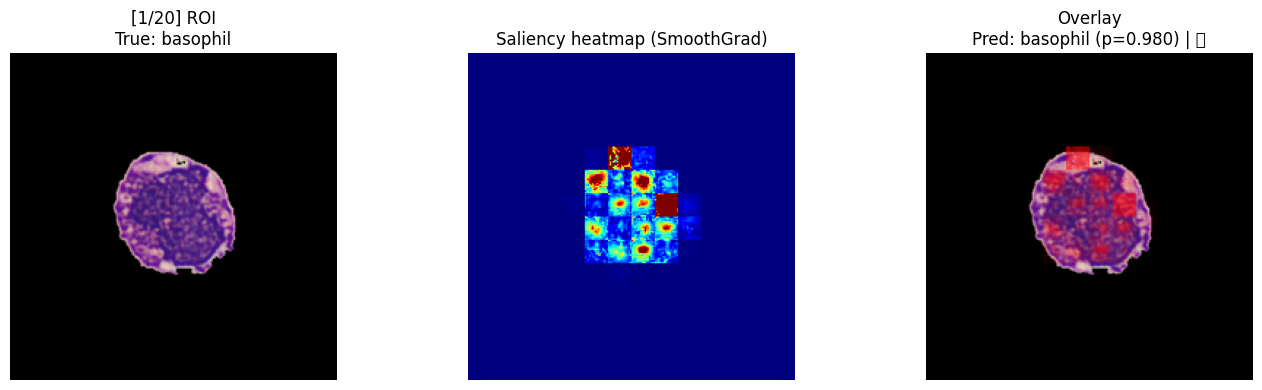

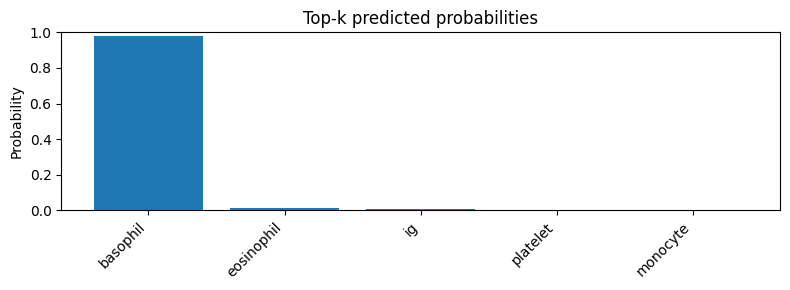

/tmp/ipython-input-2764804389.py:71: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


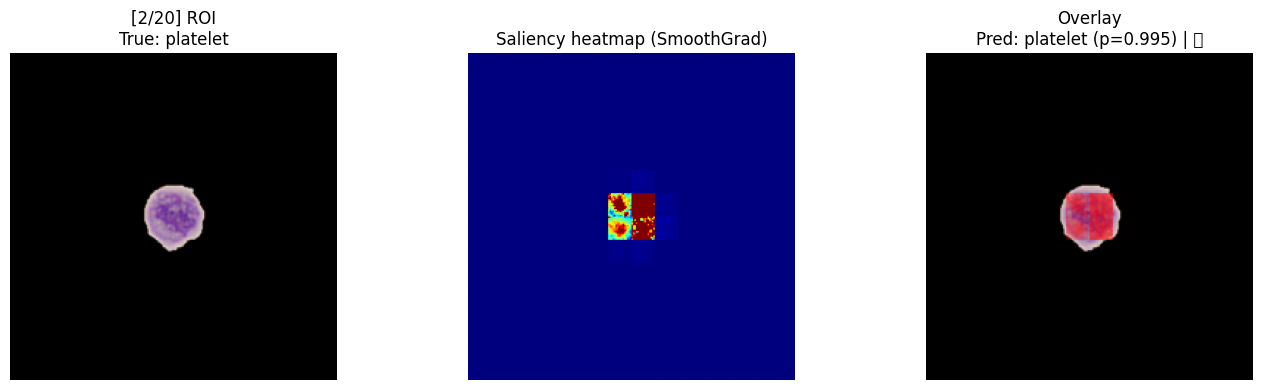

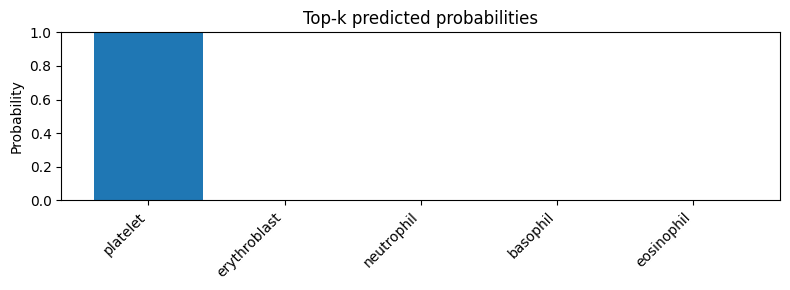

/tmp/ipython-input-2764804389.py:71: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


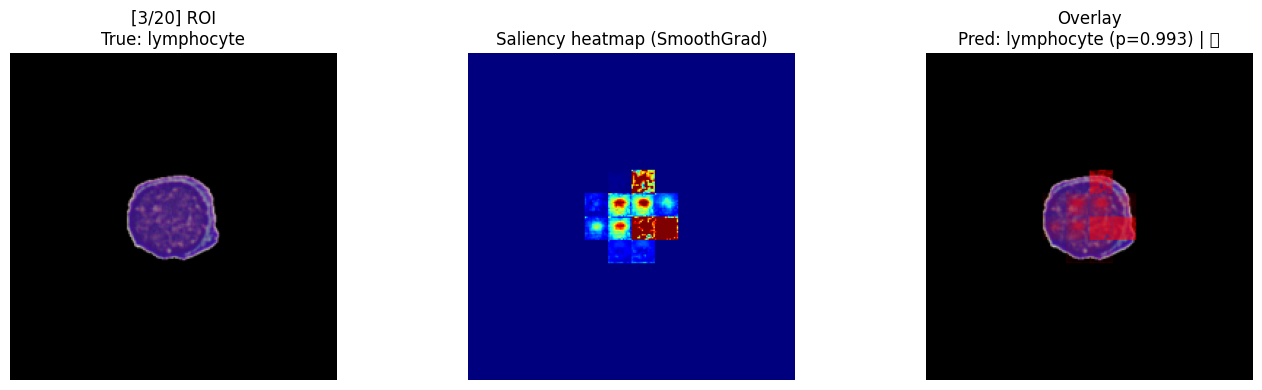

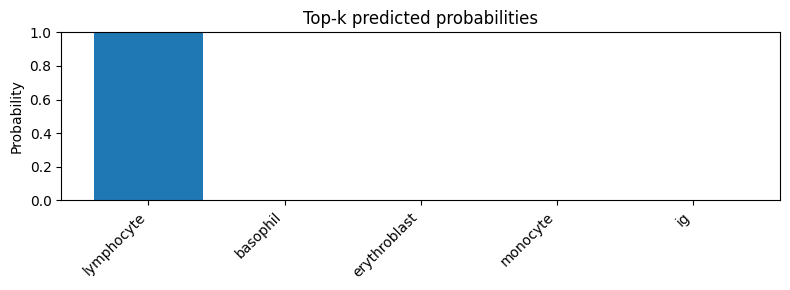

/tmp/ipython-input-2764804389.py:71: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


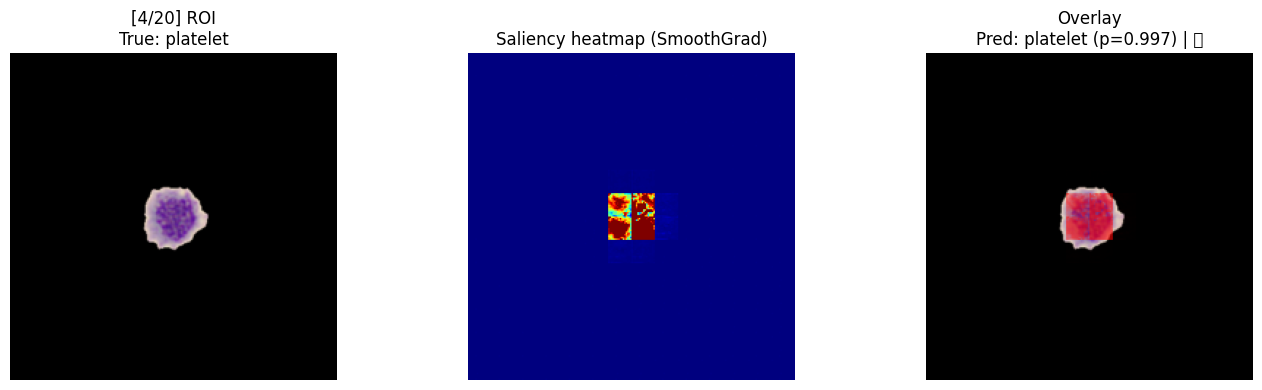

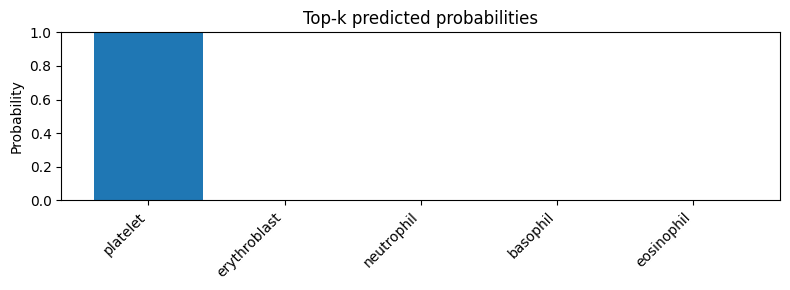

/tmp/ipython-input-2764804389.py:71: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


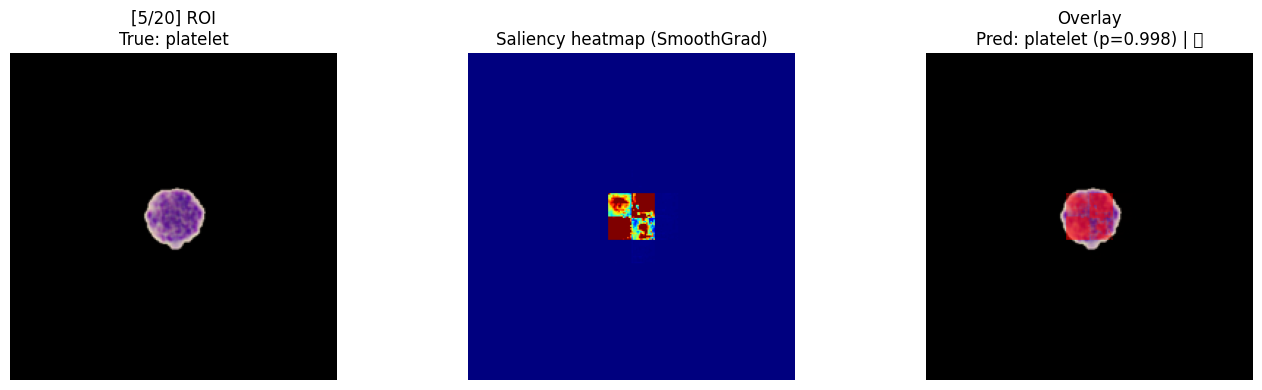

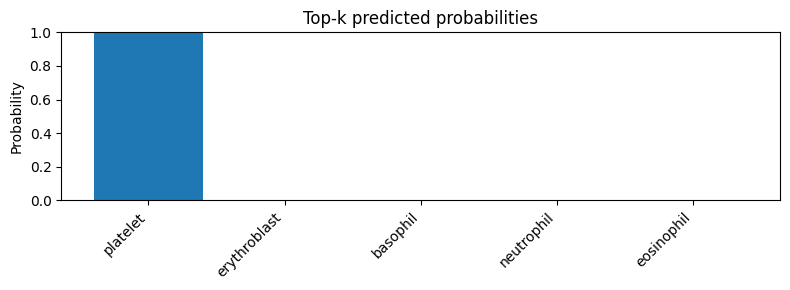

/tmp/ipython-input-2764804389.py:71: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


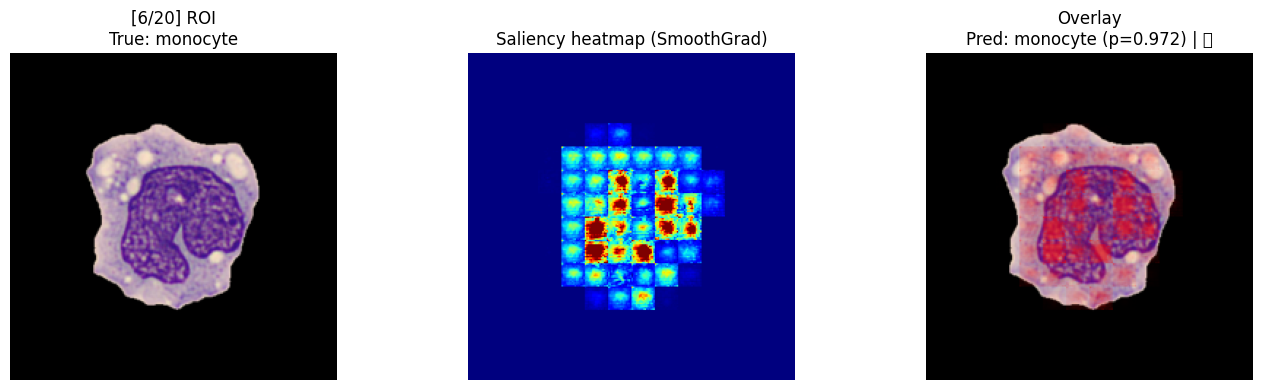

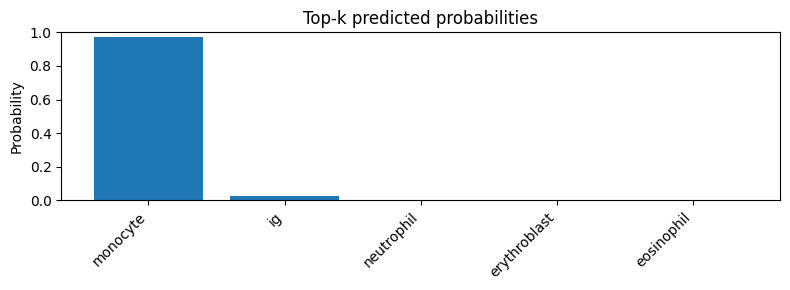

/tmp/ipython-input-2764804389.py:71: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


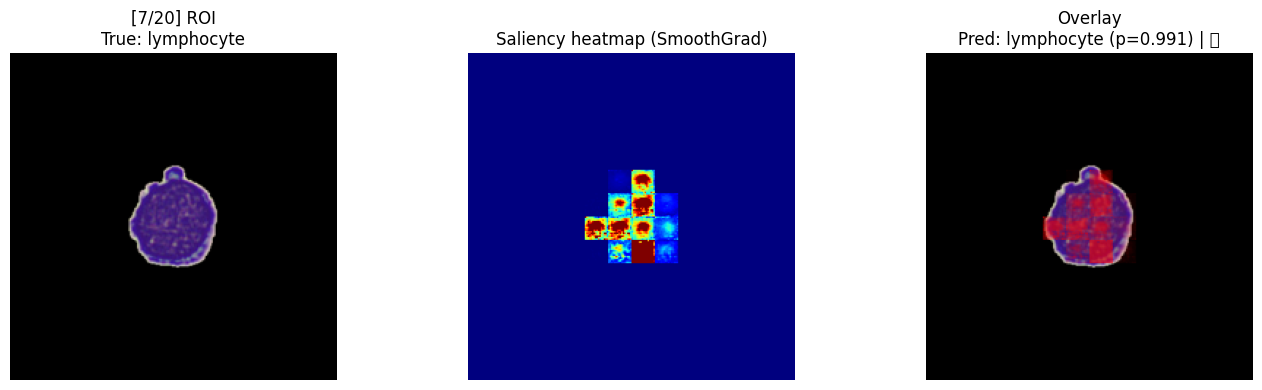

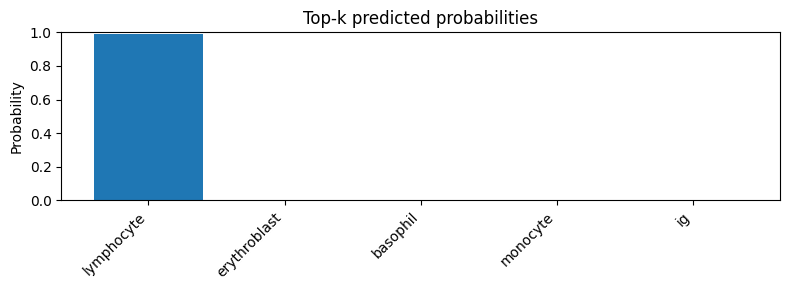

/tmp/ipython-input-2764804389.py:71: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


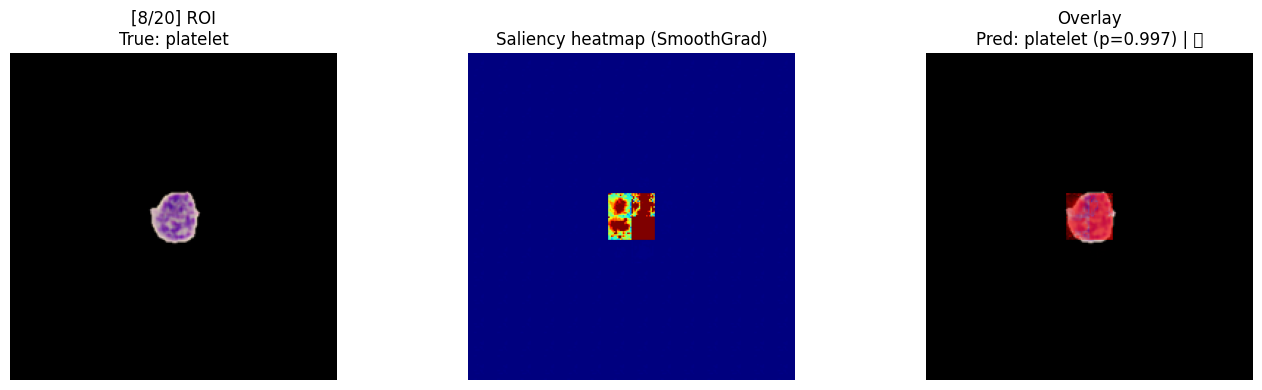

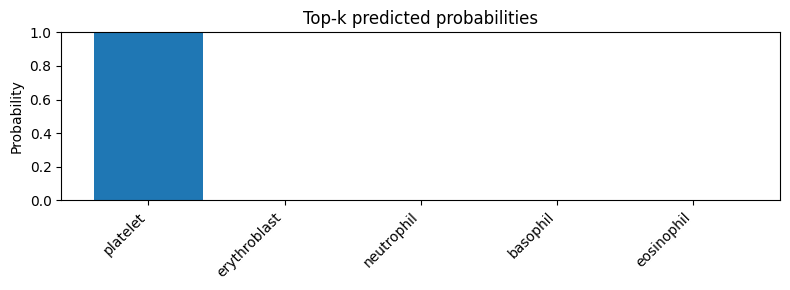

/tmp/ipython-input-2764804389.py:71: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


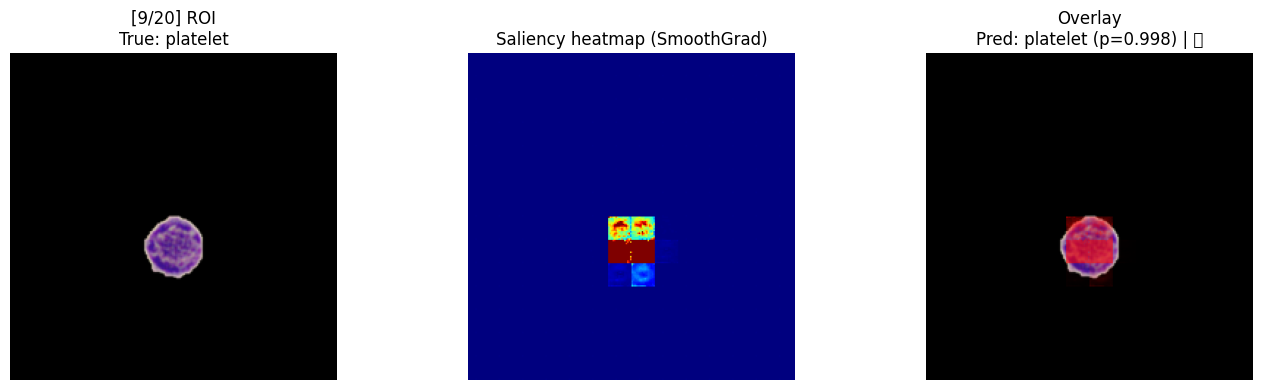

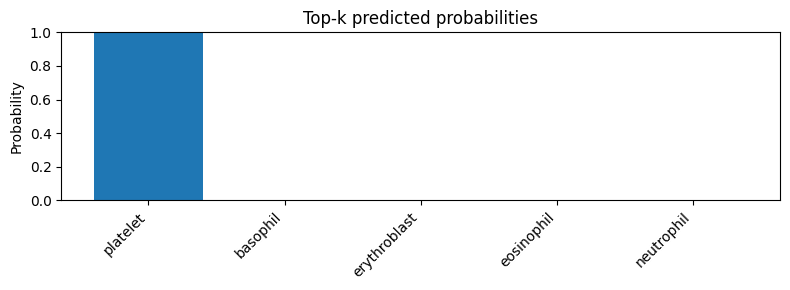

/tmp/ipython-input-2764804389.py:71: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


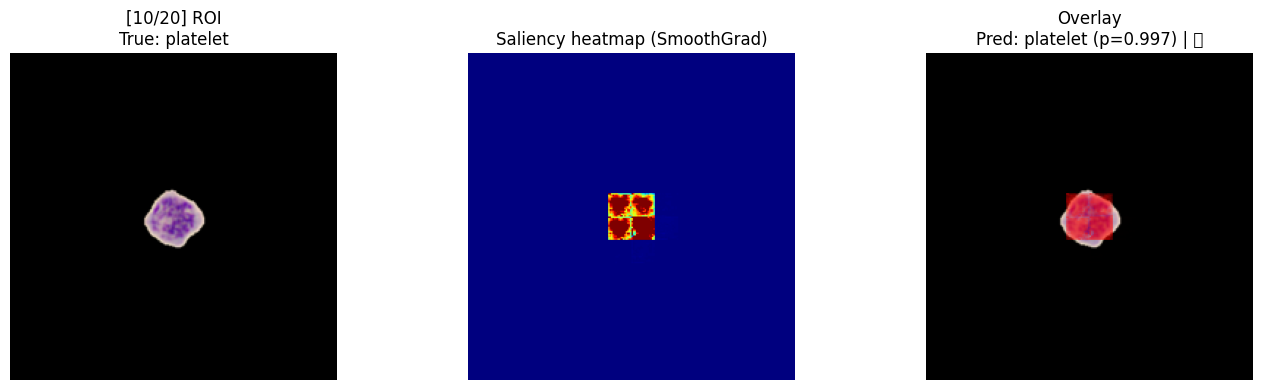

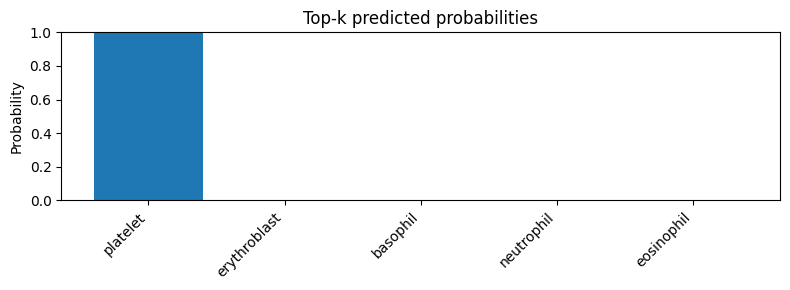

/tmp/ipython-input-2764804389.py:71: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


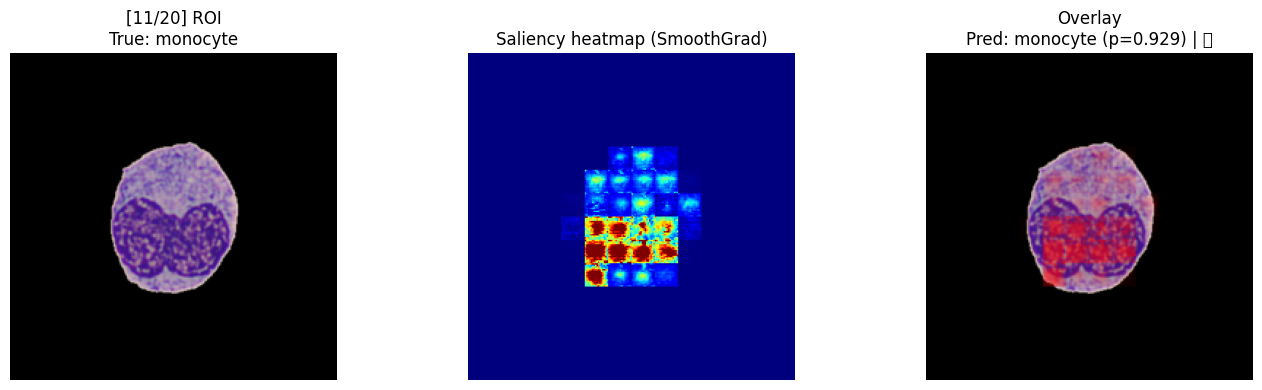

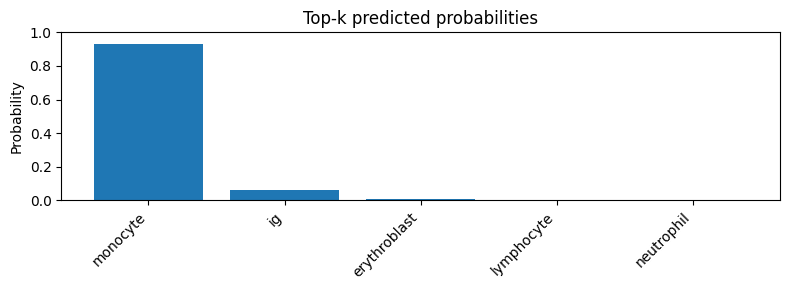

/tmp/ipython-input-2764804389.py:71: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


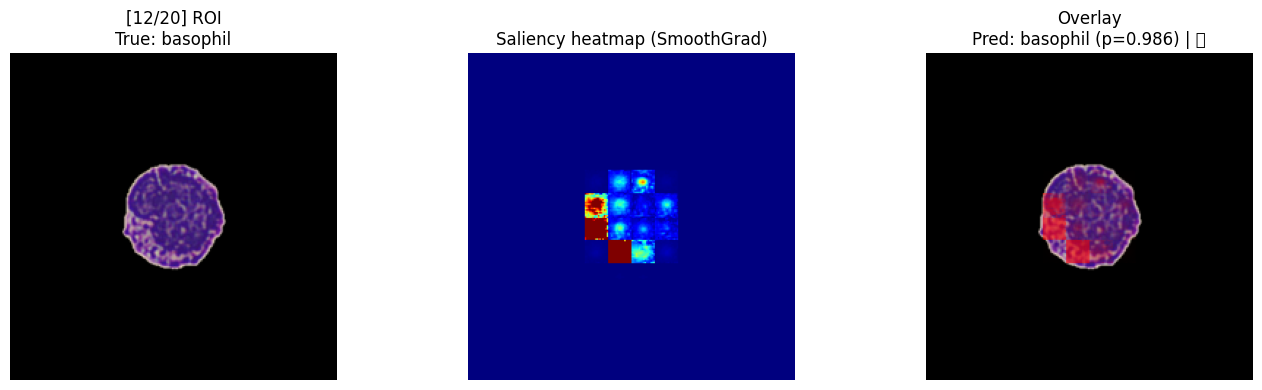

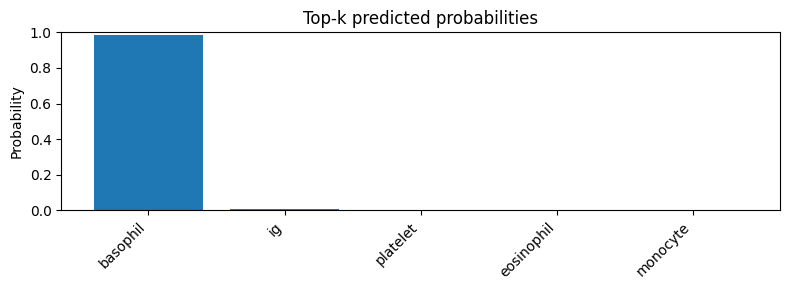

/tmp/ipython-input-2764804389.py:71: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


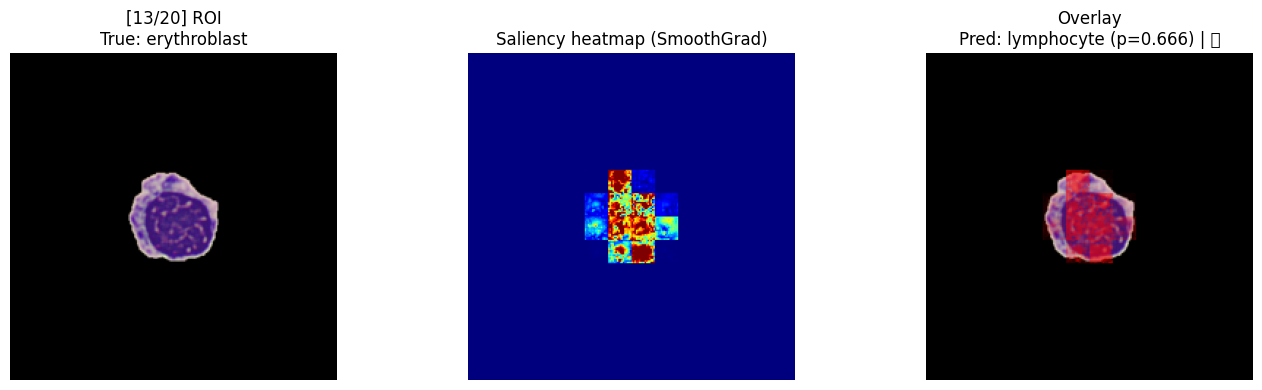

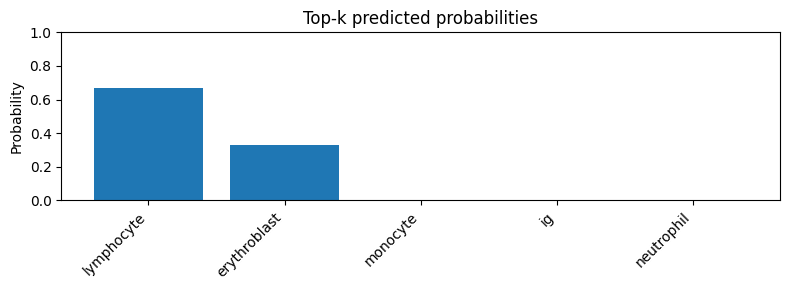

/tmp/ipython-input-2764804389.py:71: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


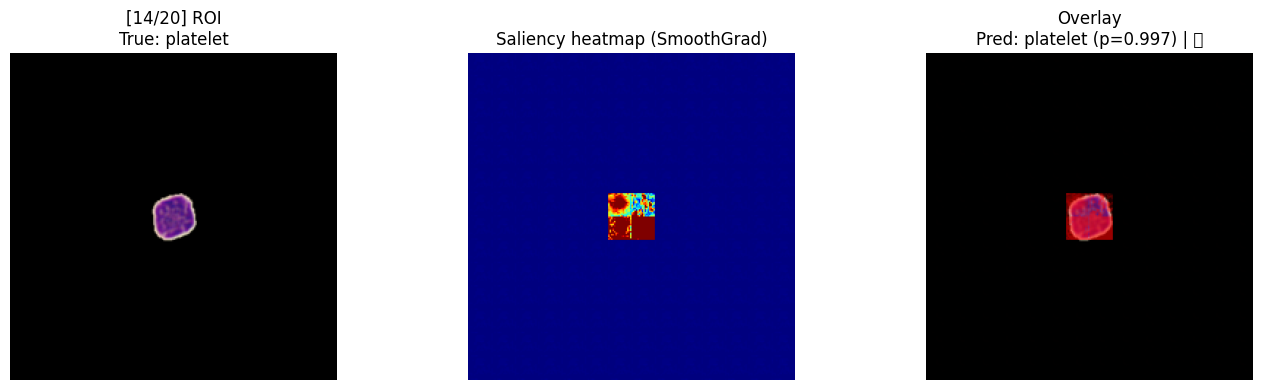

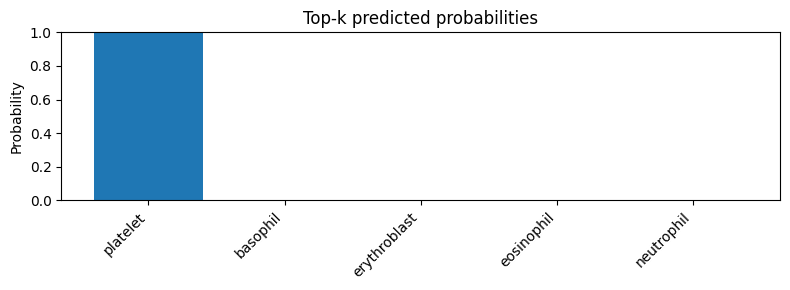

/tmp/ipython-input-2764804389.py:71: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


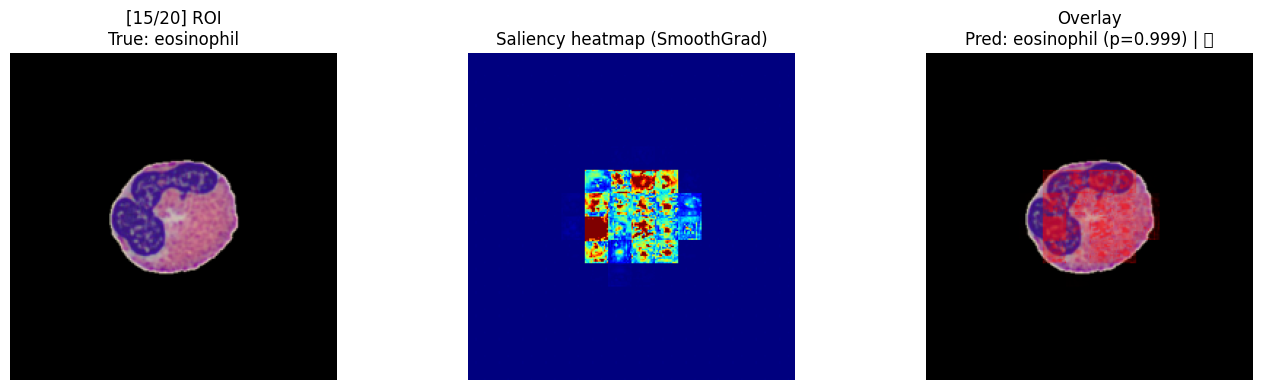

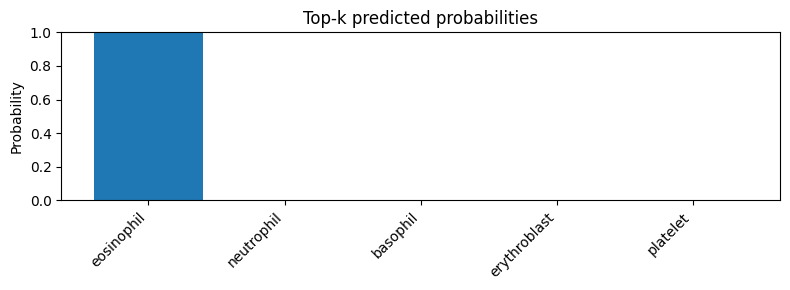

/tmp/ipython-input-2764804389.py:71: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


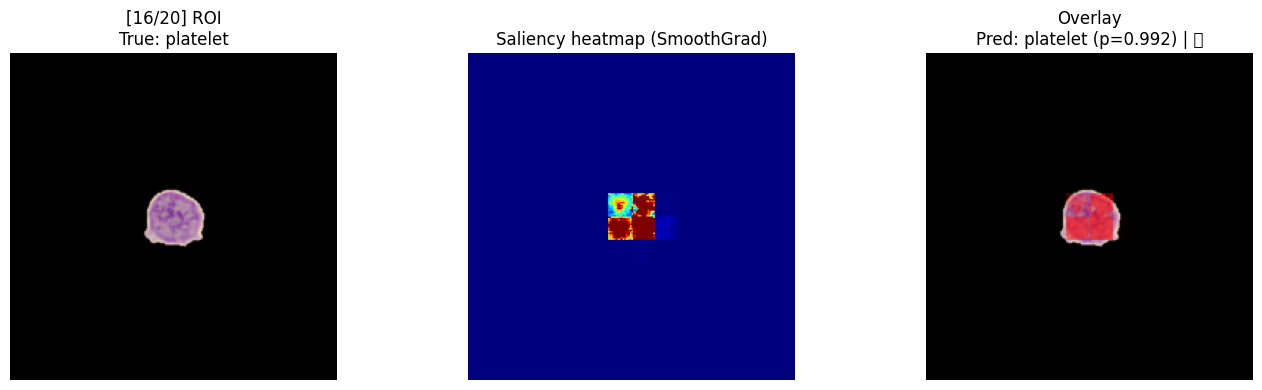

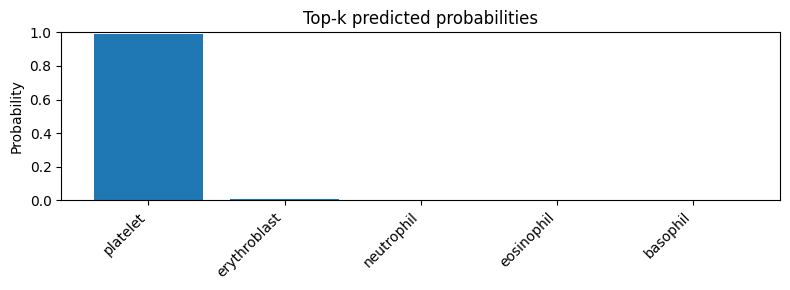

/tmp/ipython-input-2764804389.py:71: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


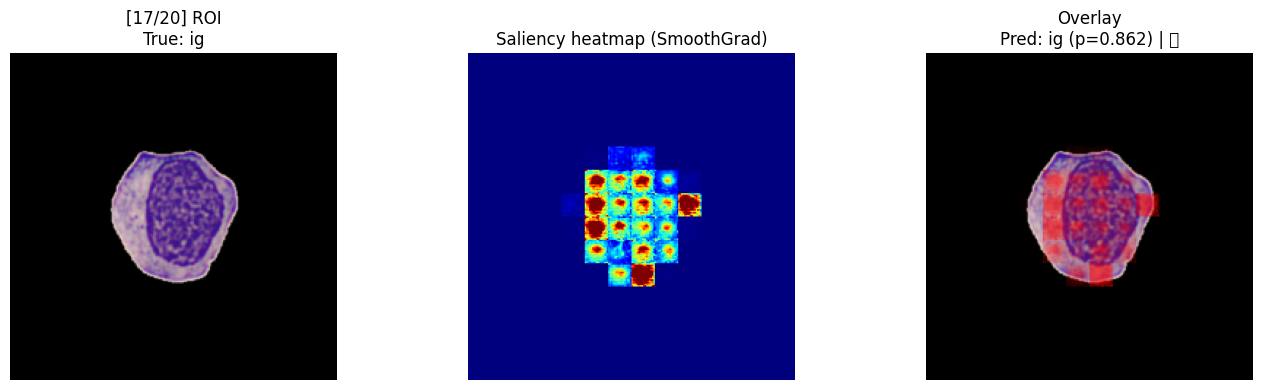

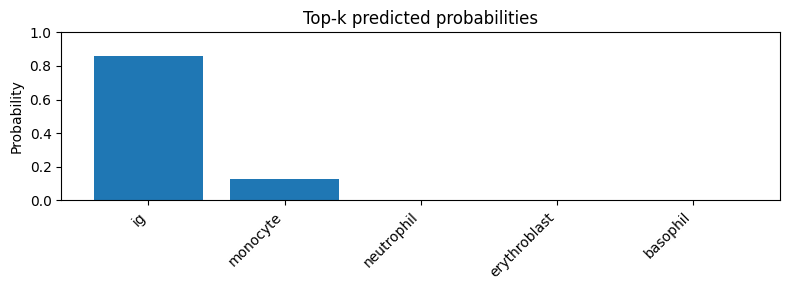

/tmp/ipython-input-2764804389.py:71: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


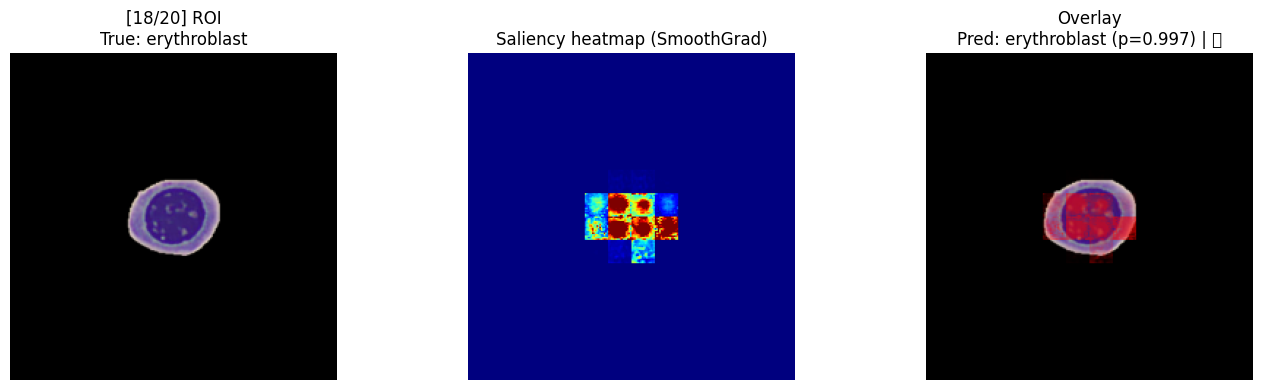

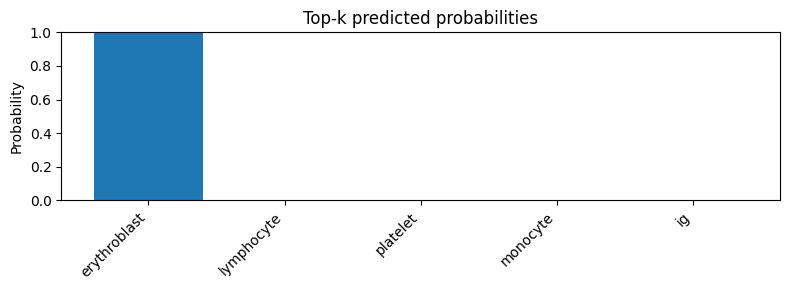

/tmp/ipython-input-2764804389.py:71: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


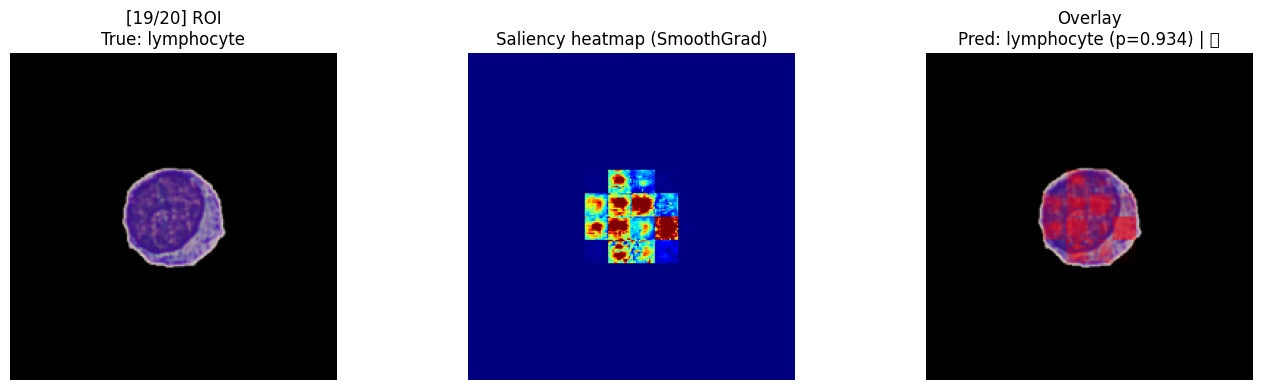

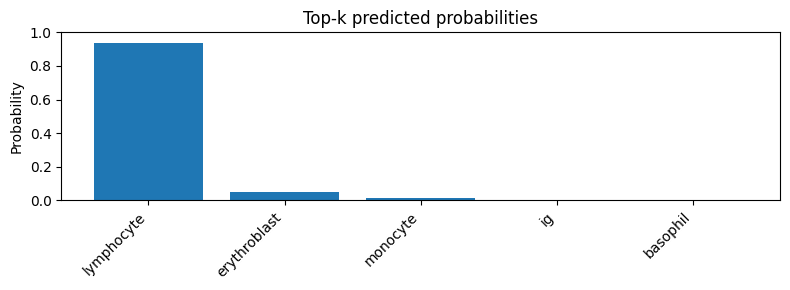

/tmp/ipython-input-2764804389.py:71: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


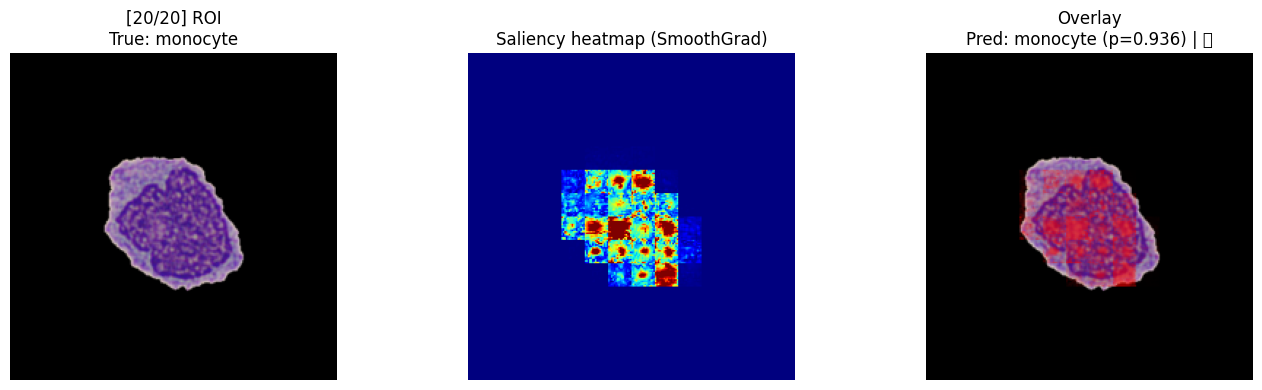

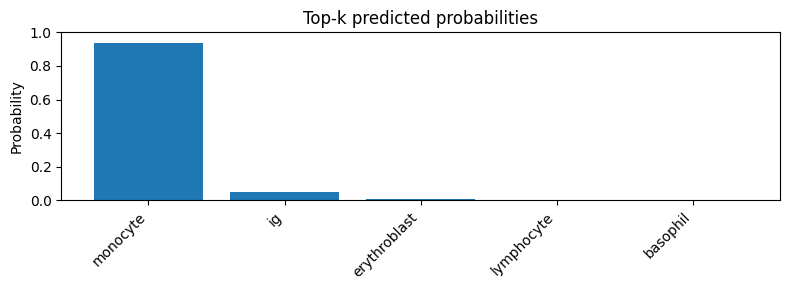

In [33]:
import random
import numpy as np
import torch
import matplotlib.pyplot as plt

# Assumes you already defined:
# - unnormalize_vit, overlay_heatmap, normalize_heatmap
# - saliency_map, smoothgrad_saliency
# - model, test_ds, base_dataset.classes (or class_names)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device).eval()

try:
    class_names = base_dataset.classes
except NameError:
    class_names = [f"class_{i}" for i in range(model.heads.head.out_features)]

def show_topk_bar(probs, class_names, topk=5, figsize=(8,3)):
    topk = min(topk, len(class_names))
    top_idx = np.argsort(probs)[::-1][:topk]
    top_probs = probs[top_idx]
    top_names = [class_names[i] for i in top_idx]

    plt.figure(figsize=figsize)
    plt.bar(range(topk), top_probs)
    plt.xticks(range(topk), top_names, rotation=45, ha="right")
    plt.ylim(0, 1)
    plt.ylabel("Probability")
    plt.title("Top-k predicted probabilities")
    plt.tight_layout()
    plt.show()

# =========================
# RUN SmoothGrad for 20 random test samples
# =========================
N = 20
N = min(N, len(test_ds))
indices = random.sample(range(len(test_ds)), N)

for i, idx in enumerate(indices, start=1):
    roi, y_true = test_ds[idx]
    x = roi.unsqueeze(0).to(device)

    # SmoothGrad saliency (NO torch.no_grad()!)
    heat, pred, pred_p, probs = smoothgrad_saliency(model, x, n_samples=20, noise_std=0.08)

    img01 = unnormalize_vit(roi.to(device))
    overlay = overlay_heatmap(img01, heat, alpha=0.60)

    true_name = class_names[int(y_true)]
    pred_name = class_names[int(pred)]
    correct = (int(pred) == int(y_true))

    plt.figure(figsize=(14,4))
    plt.subplot(1,3,1)
    plt.imshow(img01)
    plt.title(f"[{i}/{N}] ROI\nTrue: {true_name}")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(heat, cmap="jet")
    plt.title("Saliency heatmap (SmoothGrad)")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(overlay)
    plt.title(f"Overlay\nPred: {pred_name} (p={pred_p:.3f}) | {'✅' if correct else '❌'}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    show_topk_bar(probs, class_names, topk=5, figsize=(8,3))


In [34]:
import torch

save_path = "vit_wbc_roi_classifier.pt"

torch.save({
    "model_state_dict": model.state_dict(),
    "num_classes": model.heads.head.out_features,
    "class_names": class_names,
}, save_path)

print(f"✅ ViT model saved to: {save_path}")


✅ ViT model saved to: vit_wbc_roi_classifier.pt
